National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Modern Decision Making: Applied Machine Learning

Final Project: Level of income prediction (binary classification)

Student: Andrei Batyrov (Fall2022)

Date: 26-Nov-2023

##### Table of Contents

[Description](#description)

1. [Data exploration](#data-exploration)

2. [Data preprocessing](#data-preprocessing)

3. [Model training](#model-training)

4. [Summary](#summary)

In [211]:
# Essential import
import json
from itertools import combinations
import numpy as np
import pandas as pd
from scipy.stats.contingency import crosstab, association
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score, auc, average_precision_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder, WOEEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
seed = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Some helper functions.

In [2]:
def describe(series, kind, normalize=False):
    '''
    Print Pandas Series basic statistics.
    '''
    if kind not in ('num', 'cat'):
        raise ValueError("kind must be 'num' or 'cat'")
    print(f'Shape: {series.shape}')
    if kind == 'cat':
        print(f'Data type: {str(series.dtype)}')
        print(f'{series.nunique():.0f} unique')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:.0f} nulls\033[0m')
        else:
            print(f'{nulls:.0f} nulls')
        print(f"{'':->20}")
        hist = series.value_counts(dropna=False, normalize=normalize).head(10).sort_values(ascending=False)
        #print(hist.to_string(max_rows=10, name=True))
        fig, ax = plt.subplots(1, 1, figsize=(3, 0.3*min(hist.shape[0], 10)))
        ax.barh(hist.index.astype(str), width=hist.values, color='white', edgecolor='C0', alpha=0.35, hatch='.'*6)
        ax.bar_label(ax.containers[0], label_type='edge', padding=5, fontsize=9)
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        for axis in fig.get_axes():
            spines = axis.spines
            spines['bottom'].set_color('white')
            spines['top'].set_color('white')
            spines['right'].set_color('white')
            spines['left'].set_color('darkgrey')
        return hist
    else: # kind == 'num'
        print(f'Data type: {str(series.dtype)}')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:.0f} nulls\033[0m')
        else:
            print(f'{nulls:.0f} nulls')
        print(f"Min = {series.min():,.2f}")
        print(f"Max = {series.max():,.2f}")
        print(f"Mean = {series.mean():,.2f}")
        print(f"Med = {series.median():,.2f}")
        print(f"Std = {series.std(ddof=1):,.2f}")

In [3]:
def percentile_interval(array, alpha):
    '''
    Return percentiles (boundaries) of `array`, as per the significance level `alpha`.
    '''
    boundaries = np.nanpercentile(array, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # Two-sided percentiles
    return boundaries

In [4]:
def run_chi2test(*sers, alpha=0.05, verbose=True):
    observed_df = pd.DataFrame(crosstab(sers[0].fillna('Unknown'), sers[1].fillna('Unknown')).count)
    df_index = sers[0].value_counts(dropna=False).index.sort_values()
    df_columns = sers[1].value_counts(dropna=False).index.sort_values()
    observed_df.index = df_index
    observed_df.columns = df_columns
    chi2_test_result = chi2_contingency(observed_df.values)
    p_value = chi2_test_result.pvalue
    cramer_v = association(observed_df, method='cramer')
    if verbose:
        print(observed_df.to_string(sparsify=False, max_rows=5))
        print(f"{'':->20}")
        print(f'{p_value = :.2e} ({alpha = })')
        print(f'{cramer_v = :.4f}')
        print(f'`{sers[0].name}` and `{sers[1].name}` are _not_ independent') if p_value < alpha else print(f'`{sers[0].name}` and `{sers[1].name}` are independent')
    return p_value, cramer_v

In [5]:
def build_assoc_tab(df, cols):
    '''
    Build feature-feature association table based on Cramer's V statistic for each of C(n, 2) combinations, where n is the number of columns.
    '''
    assoc_tab_df = pd.DataFrame(columns=['X_1', 'X_2', 'p_value', 'cramer_v'])
    for comb in combinations(cols, 2):
        p_value, cramer_v = run_chi2test(df[comb[0]], df[comb[1]], verbose=False)
        assoc_tab_df.loc[len(assoc_tab_df)] = [comb[0], comb[1], p_value, cramer_v]
    return assoc_tab_df

In [6]:
def plot_hist(array, array2, bins, array2_perc, xlabel, title, scatter_color='C1'):
    '''
    Plot two histograms side by side.
    The left histogram plots all values of `array`.
    The right histogram plots within percentiles of `array2`, as per `array2_perc`.
    '''
    alpha = 1.0 - array2_perc / 100
    boundaries = percentile_interval(array, alpha)
    if array2 is not None:
        plt.figure(figsize=(12, 4))
        first = 1
        num_plots = 3
        plt.subplot(1, num_plots, first)
        plt.scatter(array, array2, c=scatter_color, marker='x', alpha=0.25)
        k, b = np.polyfit(array, array2, deg=1)
        fitted_lr = k * array + b
        plt.plot(array, fitted_lr, color='C0', ls='--', label='Fitted LR')
        plt.xlabel(f'{xlabel}', size=10, family='monospace')
        plt.ylabel(f'Avg target', size=10, family='monospace')
        plt.ylim([array2.min(), array2.max()])
        plt.legend()
        plt.grid(lw=0.5)
    else:
        plt.figure(figsize=(8, 4))
        first = 0
        num_plots = 2
    
    plt.subplot(1, num_plots, first + 1)
    plt.hist(array, bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n(all values)', size=10, family='monospace')
    plt.ylabel('Count', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.subplot(1, num_plots, first + 2)
    plt.hist(array[np.where((array >= boundaries[0]) & (array <= boundaries[1]))], bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n({array2_perc}%)', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.suptitle(title, size=10, family='monospace')
    plt.tight_layout();

In [311]:
def plot_bar(df, x, y, xlabel, title, kind='vertical', bar_label=False, ylim=None, rot=0):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind not in ('vertical', 'horizontal'):
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, width=0.25, align='center', color='white', alpha=0.75, hatch='.'*6)
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
        plt.ylim(ylim)
    else: # kind == 'horizontal'
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, height=0.25, align='center', color='white', alpha=0.75, hatch='.'*6)
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.xticks(rotation=rot)
    if bar_label:
        plt.gca().bar_label(plt.gca().containers[0], fmt='{:.2f}', label_type='edge', padding=5, fontsize=9)
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)
    plt.title(title, size=10, family='monospace');

In [8]:
def predict_partial(X, feature_name, estimator, kind, grid_size=10, ice_perc=95, feat_perc=95):
    '''
    Calculate partial predictions for one feature with name `feature_name` in Pandas Dataframe `X`.
    Estimator can by any object that has `predict` method: model, pipeline.
    `grid_size` controls the number of values of a feature to generate predictions for.
    Return Pandas DataFrame with:
    - feature values used for predictions, 
    - mean predictions — this is partial dependence (PD), 
    - Individual Conditional Expectation (ICE) low and high percentiles, as per `ice_perc`
    '''
    if kind not in ('num', 'cat', 'ord'):
        raise ValueError("kind must be 'num', 'cat' or 'ord'")
    grid_size = min(X[feature_name].nunique(), grid_size)
    feature_values = []
    feature_pred_means = []
    ice_los = []
    ice_his = []
    if kind == 'num':
        # For numerical features we can use either all values in its space or bounded by some percentiles
        feature_space = np.linspace(*percentile_interval(X[feature_name], alpha=1.0-feat_perc/100), grid_size)
    elif kind == 'cat':
        feature_space = X[feature_name].unique()[::X[feature_name].nunique() // grid_size]
    else: # kind == 'ord'
        feature_space = X[feature_name].sort_values().unique()[::X[feature_name].nunique() // grid_size]
    for feature_value in feature_space:
        feature_values.append(feature_value)
        feature_new = pd.Series([feature_value] * X.shape[0], name=feature_name) # Fix one feature value for all observations
        # First drop the whole feature, then concatenate its new values, i.e. replace the feature vector
        # Predict with this replaced feature vector
        feature_pred = estimator.predict(pd.concat([X.drop(columns=[feature_name]).reset_index(drop=True), feature_new], axis=1))
        feature_pred_mean = feature_pred.mean() # Partial Dependence
        feature_pred_means.append(feature_pred_mean)
        ice_lo, ice_hi = percentile_interval(feature_pred, alpha=1.0-ice_perc/100) # ICE boundaries
        ice_los.append(ice_lo)
        ice_his.append(ice_hi)
    return pd.DataFrame({'Value': feature_values, 'Pred_mean': feature_pred_means, 'ICE_lo': ice_los, 'ICE_hi': ice_his})

---
# <a id="description"></a>Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/dataset/117/census+income+kdd

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### <a id="data-exploration"></a>[25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?

In [9]:
with open('columns.json', 'r') as fh:
    cols = json.load(fh)['columns']
cols[:5]

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education']

Load the train and test datasets. Note that there are observations with values represented by `?` in some columns. We will treat them as missing/unknown values in our analysis. Combine the train and test datasets for further analysis and manipulation.

In [10]:
data = pd.concat(map(lambda x: pd.read_csv(x, na_values='?', skipinitialspace=True, header=None), ['census-income.data', 'census-income.test']), axis=0, ignore_index=True)
data.columns = cols
# Take a look at some 3 random observations
data.iloc[sorted(np.random.choice(data.shape[0], 3, replace=False))]
#data.head(3)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran admin,veterans benefits,weeks worked in year,year,target
55339,37,Not in universe,0,0,High school graduate,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,2829,0,0,Joint both under 65,Not in universe,Not in universe,Other Rel 18+ ever marr RP of subfamily,Other relative of householder,3877.23,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
180998,75,Not in universe,0,0,9th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,1379.99,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,Poland,Poland,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
271750,4,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,Black,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,2904.10,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.


In [11]:
data.shape

(299285, 42)

First, let's examine the target variable.

Shape: (299285,)
Data type: int32
2 unique
0 nulls
--------------------


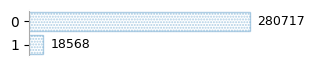

In [283]:
target = 'target'
_ = describe(data[target], 'cat')

<a id="acc-naive"></a>We can clearly see that the target variable takes only two values (levels of income). Thus, we will be solving a binary classification problem in this task. Let's encode the target variable as `1` and `0` for the further analysis. Don't forget to check that the encoding is done correctly.

Shape: (299285,)
Data type: int32
2 unique
0 nulls
--------------------


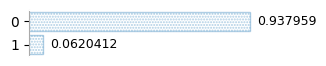

In [13]:
target_label_enc = LabelEncoder()
data[target] = target_label_enc.fit_transform(data[target])
class_labels = list(data[target].value_counts().index)
_ = describe(data[target], 'cat', normalize=True)

Note, the distribution of the target is not uniform, i.e. we have highly imbalanced data: around 94% (majority class) vs around 6% (minority class) observations $\approx$ 15:1 ratio. Therefore, we __cannot use__ the `accuracy score` to evaluate our classifier(s) without dealing with imbalance, since it makes no sense. Indeed, let's build a naive classifier that will always predict the most frequent level of income which is 0 (- 50000.), and compute the accuracy score for such predictions.

In [14]:
y_pred_naive = np.ones_like(data[target]) * _.index[0]
print(f'Predicted level of income: {y_pred_naive[:5]} ...')
print(f"Naive classifier's accuracy = {accuracy_score(data[target], y_pred_naive):.2%}")

Predicted level of income: [0 0 0 0 0] ...
Naive classifier's accuracy = 93.80%


Is the task solved? Well, if we're only interested in reporting the overall accuracy, which is frequency of the "`- 50000.`" income level in this case, regardless of any other features in our data, then yes. The problem with this classifier is that it cannot predict the minority class at all.

Let predicting the level of income "`- 50000.`" be the no-effect ($\mathcal H_0: \text{Class} = 0$), and predicting the level of income "`50000+.`" be the positive effect ($\mathcal H_1: \text{Class} = 1$). Now, __let's assume that we're interested in correctly reporting the positive effect__ from observing the features of our participants. In other words, we would like to understand the profile of those participants who earn more. Imagine, that this is important because we want to introduce a new extra income tax for individuals who earn more than 50000. If our classifier falsely reports the positive effect (falsely rejects $\mathcal H_0$, makes type I errors), then individuals who earn less than 50000 will be subject to this new extra tax burden, which is inappropriate, and thus such outcomes should be avoided. So, __our key metric will be `precision`__. Another scenario might be to find as much as possible those individuals who indeed earn more, for some further analysis. In this case we would focus on `recall (true positive rate)`. We will also look at the mean metrics such as `f1 score` to evaluate both precision and recall. Let's assume, that in this task we're not interested in correctly reporting the no-effect, so we will not look at metrics for true negative observations.

---
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step

Let's choose the __Stratified K-Fold cross-validation strategy__ applied on the train data. It is a variation of the K-Fold cross-validation strategy that uses stratified folds. This strategy allows to keep proportions of observations selected into folds, as per the target class distribution, thus taking into account the imbalance of our data.

The advantages of this strategy:
- it does not require any additional validation data, since the validation samples are constructed from the train data itself;
- it does not require any preprocessing of the train data, since the folds are created during the very process of cross-validation on the fly.

However, this strategy has disadvantages too:
- since one of the folds is used for validation, not all train data is used for fitting the model in every training round;
- the model (or pipeline) has to be trained as many times as there are folds, which takes time.

This will be our base strategy. Additionally, let's allocate some fixed sample (10%) from our data, specifically for validation purposes. This sample might be used in boosting models, but it will not be used in models that are evaluated with cross-validation. So we will split our data into 3 parts:
- train, used for training and cross-validation of models;
- val, used for validation of boosting models and other possible experiments;
- test, used for final estimation of models.

The split will be done in section 3 below.

---
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

Now, let's look closer at our predictors (features).
- for categorical and ordinal features we will check association with the target by using $\chi^2$-test by looking at the test's $p$-value and Cramer's V statistic. For simplicity, we'll ignore the $\chi^2$-test's requirement of more than 5 counts in the contingency table cells.
- for numerical features we will check Pearson's correlation with the target (linear). However, since the target is binary it does not make much sense to compute the correlation coefficient directly. Instead, we'll use one of disadvantages of the target encoding technique which is target leakage — we will check the correlation between a numerical feature and its target-encoded copy. Since, our numerical features are integers (or they can be binned, anyway), we can divide them in separate "categories" corresponding to their discrete values. Now, target encoding returns the average target value for each "category" of a feature, which is the probability of class 1, in fact. That is, it transforms a feature into the target's probability space (continuos), so we can estimate the correlation.

In [15]:
feat_eng_target_enc = TargetEncoder(target_type='binary', random_state=seed)

In [16]:
data.drop(columns=target).dtypes.value_counts(normalize=False)

object     28
int64      12
float64     1
Name: count, dtype: int64

In [17]:
data.drop(columns=target).select_dtypes(int).columns

Index(['age', 'detailed industry recode', 'detailed occupation recode',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'num persons worked for employer',
       'own business or self employed', 'veterans benefits',
       'weeks worked in year', 'year'],
      dtype='object')

In [18]:
data.drop(columns=target).columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
 

In [19]:
num_cols, cat_cols = [], []

Pearson corr coef = 0.54
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 90.00
Mean = 34.54
Med = 33.00
Std = 22.32


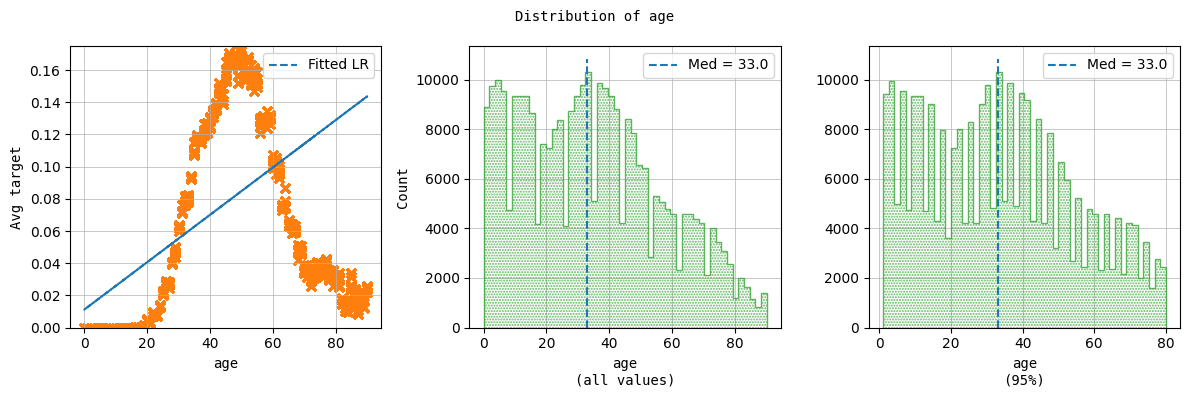

In [20]:
# 1. Age
feature_name = 'age'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

<a id="feature-age"></a>`age` looks like a continuous variable. Middle age participants earn more than younger and older ones. We will keep this feature so far.

In [21]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: object
9 unique
0 nulls
--------------------


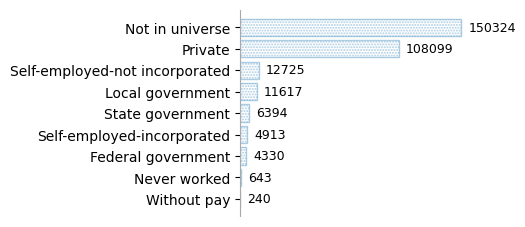

In [285]:
# 2. Class of worker
feature_name = 'class of worker'
_ = describe(data[feature_name], 'cat')

In [23]:
_ = run_chi2test(data[feature_name], data[target])

target                  0     1
class of worker                
Federal government   3459   871
Local government    10332  1285
...                   ...   ...
State government     5646   748
Without pay           238     2
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2591
`class of worker` and `target` are _not_ independent


We have confirmed that `class of worker` and target are not independent indeed, thus we will keep this feature so far.

In [24]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

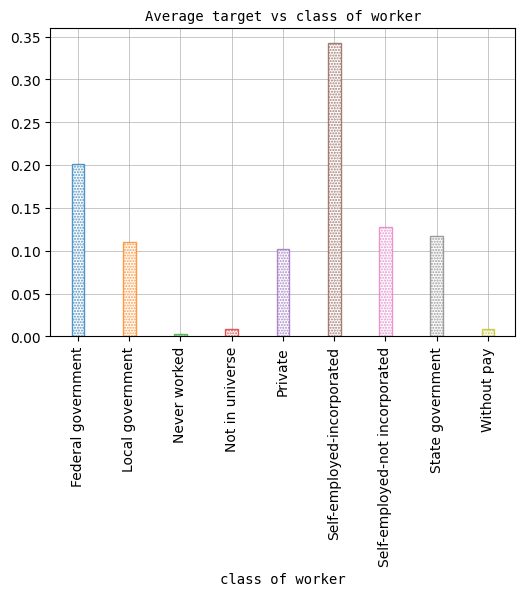

In [309]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

Self-employed-incorporated category is the leader. Lawyers?

Shape: (299285,)
Data type: int64
52 unique
0 nulls
--------------------


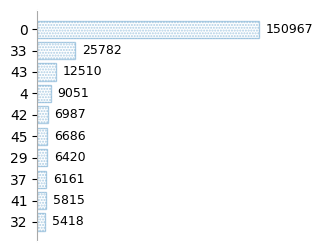

In [26]:
# 3. Detailed industry recode
feature_name = 'detailed industry recode'
_ = describe(data[feature_name], 'cat')

In [27]:
_ = run_chi2test(data[feature_name], data[target])

target                         0     1
detailed industry recode              
0                         149616  1351
1                           1137    71
...                          ...   ...
50                          2089   436
51                            43     9
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2931
`detailed industry recode` and `target` are _not_ independent


We have confirmed that `detailed industry recode` and target are not independent indeed, thus we will keep this feature so far.

In [28]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: int64
47 unique
0 nulls
--------------------


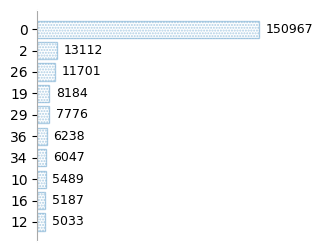

In [29]:
# 4. Detailed occupation recode
feature_name = 'detailed occupation recode'
_ = describe(data[feature_name], 'cat')

In [30]:
_ = run_chi2test(data[feature_name], data[target])

target                           0     1
detailed occupation recode              
0                           149616  1351
1                              617   203
...                            ...   ...
45                             226    26
46                              43     9
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.4380
`detailed occupation recode` and `target` are _not_ independent


We have confirmed that `detailed occupation recode` and target are not independent indeed, thus we will keep this feature so far.

In [31]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
17 unique
0 nulls
--------------------


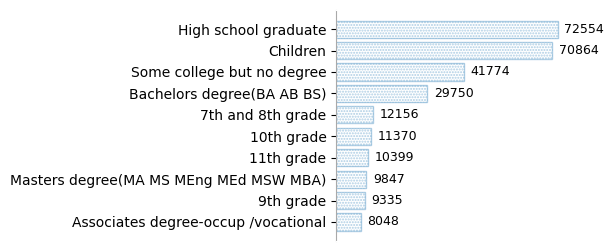

In [32]:
# 5. Education
feature_name = 'education'
_ = describe(data[feature_name], 'cat')

In [33]:
_ = run_chi2test(data[feature_name], data[target])

target                                      0     1
education                                          
10th grade                              11274    96
11th grade                              10283   116
...                                       ...   ...
Prof school degree (MD DDS DVM LLB JD)   1222  1447
Some college but no degree              39145  2629
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.3895
`education` and `target` are _not_ independent


We have confirmed that `education` and target are not independent indeed, thus we will keep this feature so far.

In [34]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

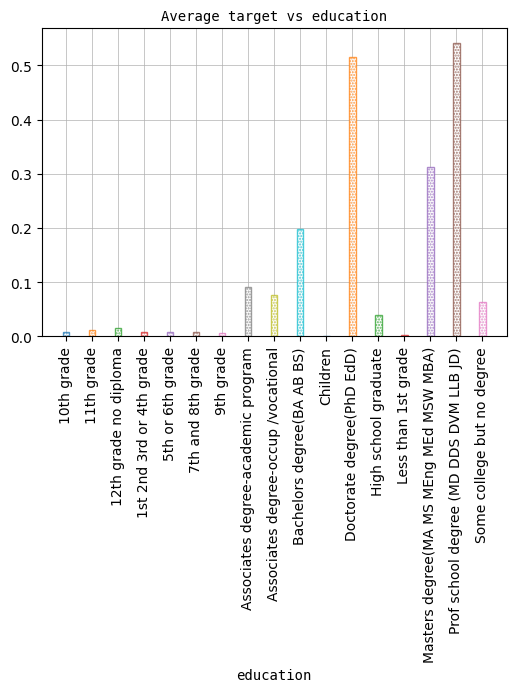

In [35]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

No wonder, that participants with doctorate, masters and professional school degree earn more.

Pearson corr coef = 0.09
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 9,999.00
Mean = 55.11
Med = 0.00
Std = 273.34


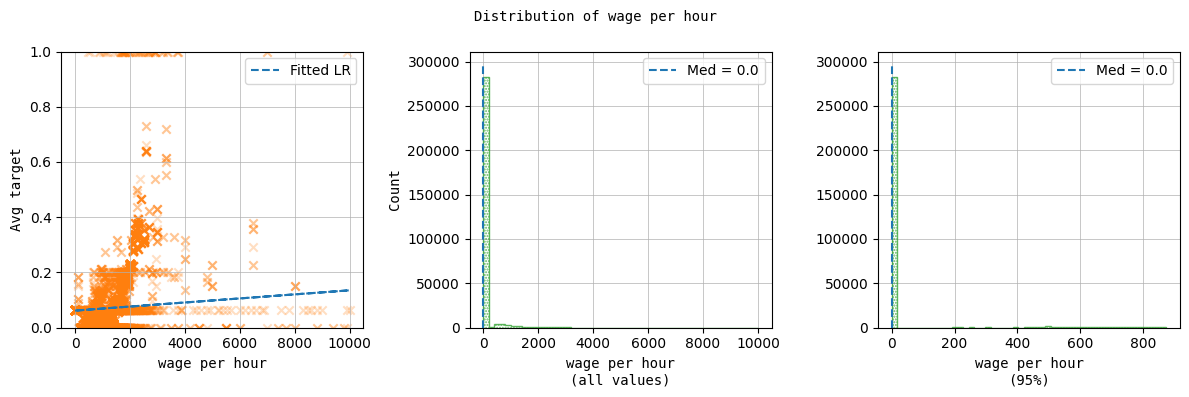

In [36]:
# 6. Wage per hour
feature_name = 'wage per hour'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
1425 unique
0 nulls
--------------------


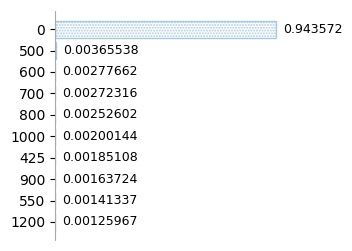

In [37]:
_ = describe(data[feature_name], 'cat', normalize=True)

`wage per hour` looks like a continuous variable. It has over 94% of the same value of 0.0, that is the feature does not variate much. Also it is very loosely linearly correlated with the target, thus we will not use it in our model.

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


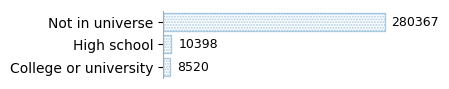

In [38]:
# 7. Enroll in edu inst last wk
feature_name = 'enroll in edu inst last wk'
_ = describe(data[feature_name], 'cat')

In [39]:
_ = run_chi2test(data[feature_name], data[target])

target                           0      1
enroll in edu inst last wk               
College or university         8485     35
High school                  10393      5
Not in universe             261839  18528
--------------------
p_value = 1.40e-271 (alpha = 0.05)
cramer_v = 0.0646
`enroll in edu inst last wk` and `target` are _not_ independent


We have confirmed that `enroll in edu inst last wk` and target are not independent indeed, thus we will keep this feature so far. Interestingly, there are high school students who earn more than 50,000.

In [40]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
7 unique
0 nulls
--------------------


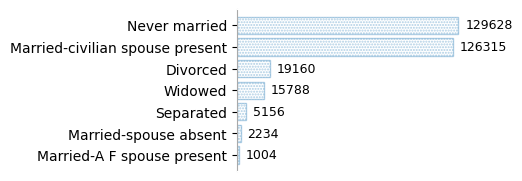

In [41]:
# 8. Marital stat
feature_name = 'marital stat'
_ = describe(data[feature_name], 'cat')

In [42]:
_ = run_chi2test(data[feature_name], data[target])

target                          0     1
marital stat                           
Divorced                    17596  1564
Married-A F spouse present    983    21
...                           ...   ...
Separated                    4927   229
Widowed                     15270   518
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1981
`marital stat` and `target` are _not_ independent


We have confirmed that `marital stat` and target are not independent indeed, thus we will keep this feature so far.

In [43]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

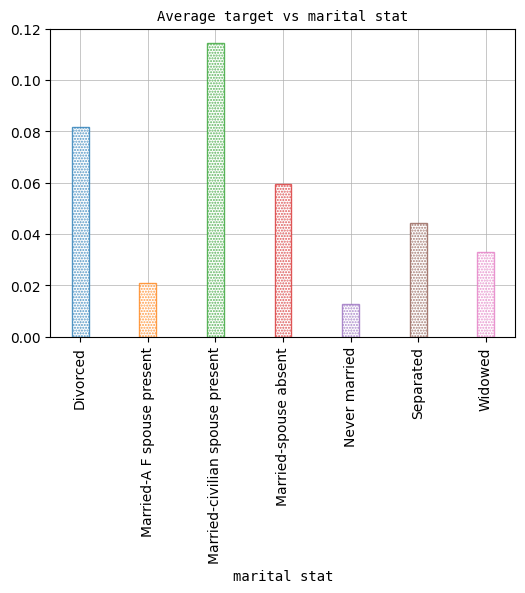

In [44]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

Married-civilian spouse present is the leader.

Shape: (299285,)
Data type: object
24 unique
0 nulls
--------------------


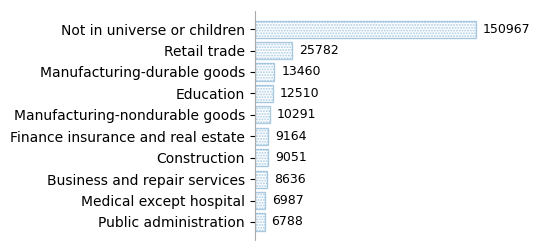

In [45]:
# 9. Major industry code
feature_name = 'major industry code'
_ = describe(data[feature_name], 'cat')

In [46]:
_ = run_chi2test(data[feature_name], data[target])

target                              0    1
major industry code                       
Agriculture                      4218  263
Armed Forces                       43    9
...                               ...  ...
Utilities and sanitary services  1354  394
Wholesale trade                  4575  843
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2789
`major industry code` and `target` are _not_ independent


We have confirmed that `major industry code` and target are not independent indeed, thus we will keep this feature so far.

In [47]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
15 unique
0 nulls
--------------------


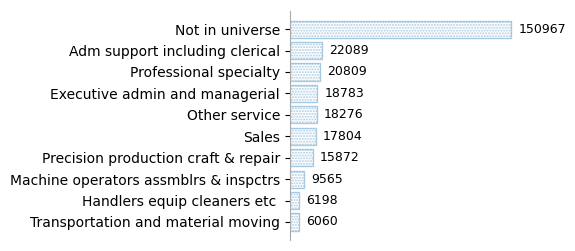

In [48]:
# 10. Major occupation code
feature_name = 'major occupation code'
_ = describe(data[feature_name], 'cat')

In [49]:
_ = run_chi2test(data[feature_name], data[target])

target                                  0    1
major occupation code                         
Adm support including clerical      21410  679
Armed Forces                           43    9
...                                   ...  ...
Technicians and related support      3973  517
Transportation and material moving   5641  419
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.3663
`major occupation code` and `target` are _not_ independent


We have confirmed that `major occupation code` and target are not independent indeed, thus we will keep this feature so far.

In [50]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

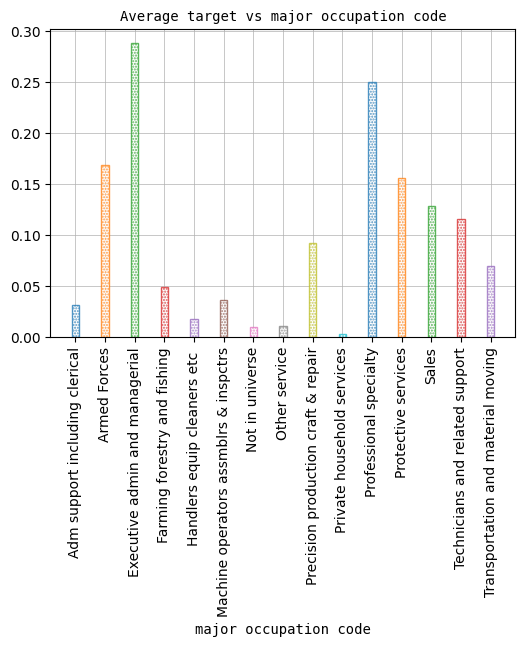

In [51]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

No surprise, managerial category is the leader.

Shape: (299285,)
Data type: object
5 unique
0 nulls
--------------------


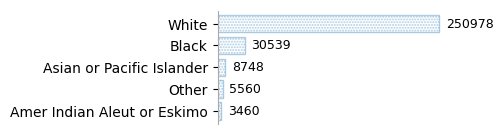

In [52]:
# 11. Race
feature_name = 'race'
_ = describe(data[feature_name], 'cat')

In [53]:
_ = run_chi2test(data[feature_name], data[target])

target                            0      1
race                                      
Amer Indian Aleut or Eskimo    3383     77
Asian or Pacific Islander      8121    627
Black                         29722    817
Other                          5434    126
White                        234057  16921
--------------------
p_value = 1.16e-222 (alpha = 0.05)
cramer_v = 0.0588
`race` and `target` are _not_ independent


We have confirmed that `race` and target are not independent indeed, thus we will keep this feature so far.

In [54]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
9 unique
1279 nulls
--------------------


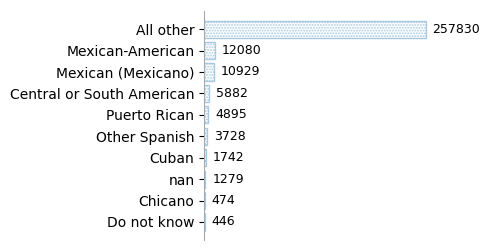

In [55]:
# 12. Hispanic origin
feature_name = 'hispanic origin'
_ = describe(data[feature_name], 'cat')

In [56]:
_ = run_chi2test(data[feature_name], data[target])

target                          0      1
hispanic origin                         
All other                  240206  17624
Central or South American    5755    127
...                           ...    ...
Puerto Rican                 4790    105
NaN                          1206     73
--------------------
p_value = 1.60e-289 (alpha = 0.05)
cramer_v = 0.0677
`hispanic origin` and `target` are _not_ independent


We have confirmed that `hispanic origin` and target are not independent indeed, thus we will keep this feature so far.

In [57]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
2 unique
0 nulls
--------------------


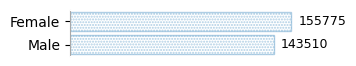

In [58]:
# 13. Sex
feature_name = 'sex'
_ = describe(data[feature_name], 'cat')

In [59]:
_ = run_chi2test(data[feature_name], data[target])

target       0      1
sex                  
Female  151807   3968
Male    128910  14600
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1579
`sex` and `target` are _not_ independent


We have confirmed that `sex` and target are not independent indeed, thus we will keep this feature so far. Interestingly, men look to earn more than women.

In [60]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

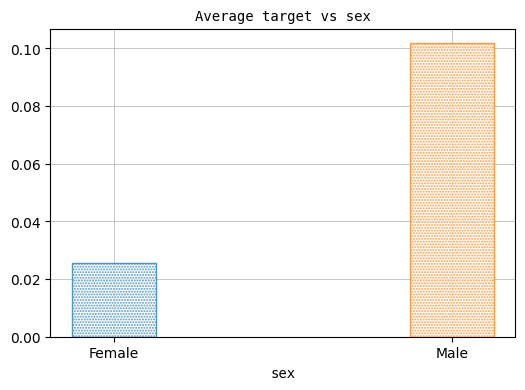

In [61]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=0)

No comments!

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


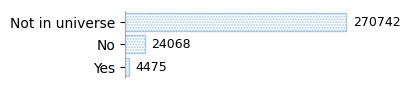

In [62]:
# 14. Member of a labor union
feature_name = 'member of a labor union'
_ = describe(data[feature_name], 'cat')

In [63]:
_ = run_chi2test(data[feature_name], data[target])

target                        0      1
member of a labor union               
No                        21356   2712
Not in universe          255499  15243
Yes                        3862    613
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.0742
`member of a labor union` and `target` are _not_ independent


We have confirmed that `member of a labor union` and target are not independent indeed, thus we will keep this feature so far.

In [64]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
6 unique
0 nulls
--------------------


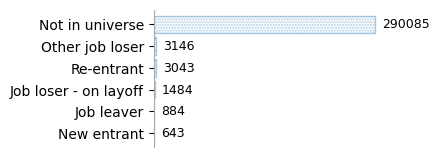

In [65]:
# 15. Reason for unemployment
feature_name = 'reason for unemployment'
_ = describe(data[feature_name], 'cat')

In [66]:
_ = run_chi2test(data[feature_name], data[target])

target                      0    1
reason for unemployment           
Job leaver                853   31
Job loser - on layoff    1448   36
...                       ...  ...
Other job loser          2986  160
Re-entrant               3015   28
--------------------
p_value = 8.63e-51 (alpha = 0.05)
cramer_v = 0.0286
`reason for unemployment` and `target` are _not_ independent


We have confirmed that `reason for unemployment` and target are not independent indeed, thus we will keep this feature so far.

In [67]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
8 unique
0 nulls
--------------------


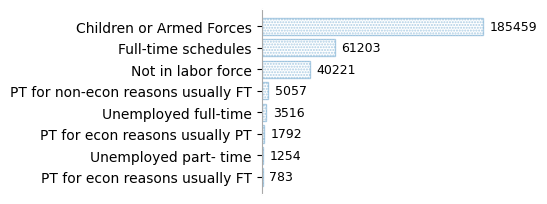

In [68]:
# 16. Full or part time employment stat
feature_name = 'full or part time employment stat'
_ = describe(data[feature_name], 'cat')

In [69]:
_ = run_chi2test(data[feature_name], data[target])

target                                  0     1
full or part time employment stat              
Children or Armed Forces           176707  8752
Full-time schedules                 53121  8082
...                                   ...   ...
Unemployed full-time                 3390   126
Unemployed part- time                1224    30
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1604
`full or part time employment stat` and `target` are _not_ independent


We have confirmed that `full or part time employment stat` and target are not independent indeed, thus we will keep this feature so far.

In [70]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

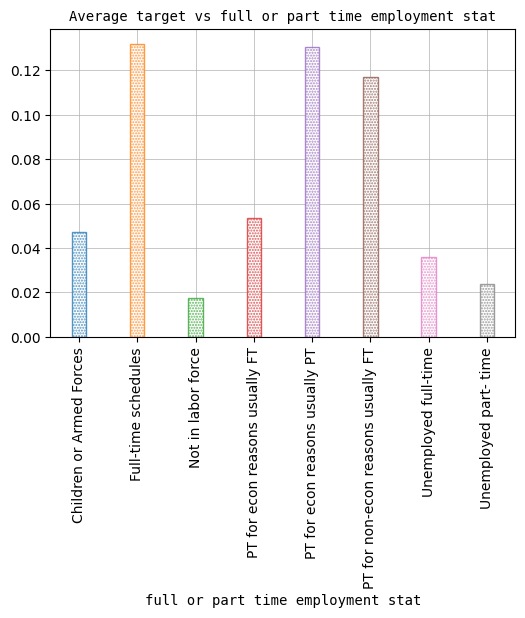

In [71]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

No clear leader: both full-timers and part-timers earn more than unemployed — what a surprise!

Pearson corr coef = 0.65
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 431.74
Med = 0.00
Std = 4,670.77


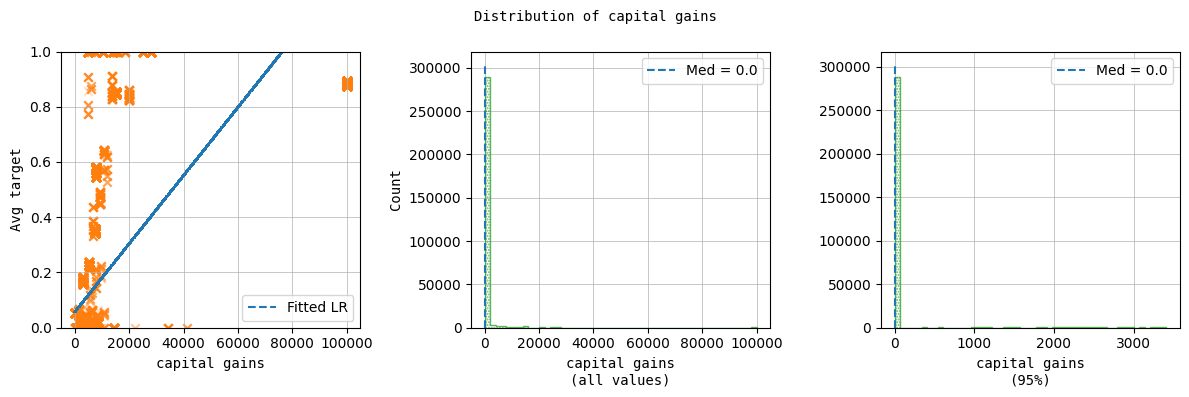

In [72]:
# 17. Capital gains
feature_name = 'capital gains'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
133 unique
0 nulls
--------------------


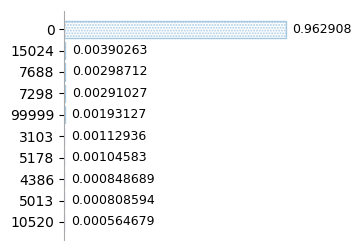

In [73]:
_ = describe(data[feature_name], 'cat', normalize=True)

`capital gains` looks like a continuous variable. It has over 96% of the same value of 0.0, that is the feature does not variate much, but still it's linearly correlated with the target, thus we will keep this feature so far.

In [74]:
num_cols.append(feature_name)

Pearson corr coef = 0.59
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 4,608.00
Mean = 36.85
Med = 0.00
Std = 269.79


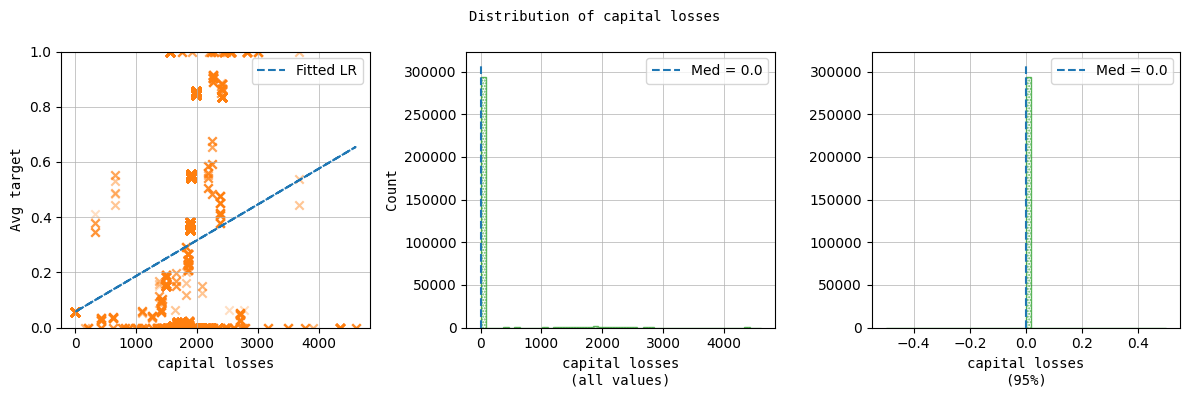

In [75]:
# 18. Capital losses
feature_name = 'capital losses'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
114 unique
0 nulls
--------------------


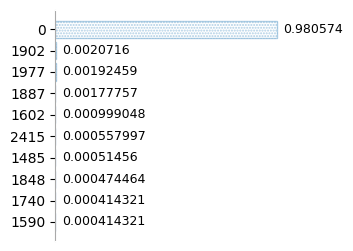

In [76]:
_ = describe(data[feature_name], 'cat', normalize=True)

`capital losses` looks like a continuous variable. It has over 98% of the same value of 0.0, that is the feature does not variate much, but still it's linearly correlated with the target, thus we will keep this feature so far.

In [77]:
num_cols.append(feature_name)

Pearson corr coef = 0.51
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 195.85
Med = 0.00
Std = 1,937.85


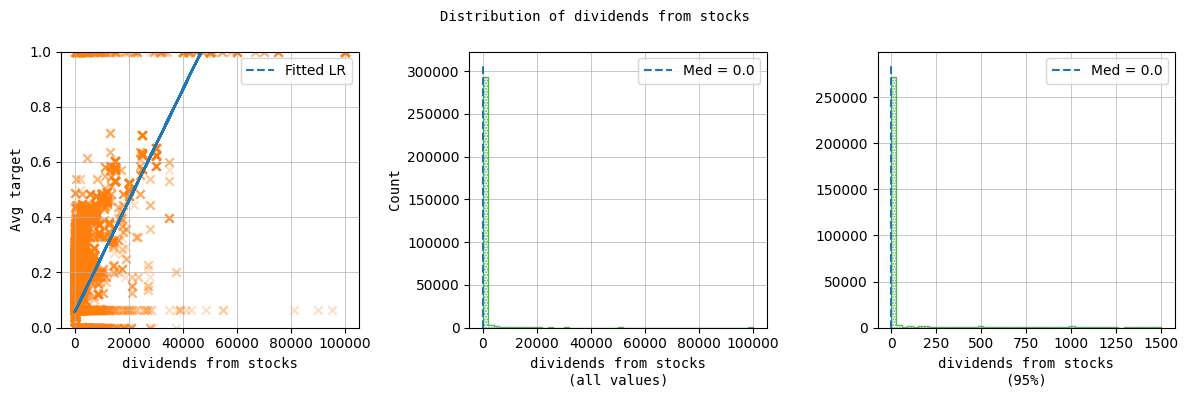

In [78]:
# 19. Dividends from stocks
feature_name = 'dividends from stocks'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
1675 unique
0 nulls
--------------------


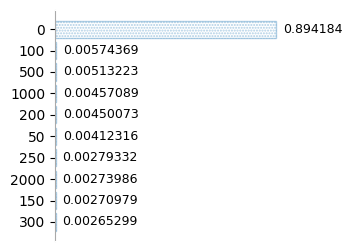

In [79]:
_ = describe(data[feature_name], 'cat', normalize=True)

`dividends from stocks` looks like a continuous variable. It has over 89% of the same value of 0.0, that is the feature does not variate much, but still it's linearly correlated with the target, thus we will keep this feature so far.

In [80]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: object
6 unique
0 nulls
--------------------


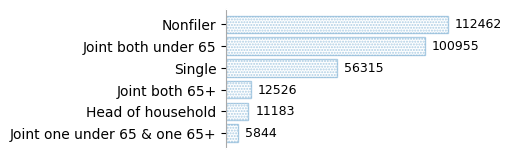

In [81]:
# 20. Tax filer stat
feature_name = 'tax filer stat'
_ = describe(data[feature_name], 'cat')

In [82]:
_ = run_chi2test(data[feature_name], data[target])

target                  0     1
tax filer stat                 
Head of household   10521   662
Joint both 65+      11870   656
...                   ...   ...
Nonfiler           112412    50
Single              52903  3412
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2302
`tax filer stat` and `target` are _not_ independent


We have confirmed that `tax filer stat` and target are not independent indeed, thus we will keep this feature so far.

In [83]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
6 unique
0 nulls
--------------------


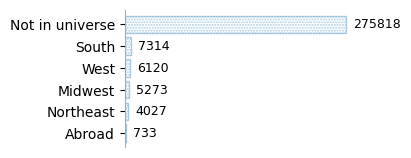

In [84]:
# 21. Region of previous residence
feature_name = 'region of previous residence'
_ = describe(data[feature_name], 'cat')

In [85]:
_ = run_chi2test(data[feature_name], data[target])

target                           0    1
region of previous residence           
Abroad                         707   26
Midwest                       5103  170
...                            ...  ...
South                         7048  266
West                          5867  253
--------------------
p_value = 1.01e-48 (alpha = 0.05)
cramer_v = 0.0280
`region of previous residence` and `target` are _not_ independent


We have confirmed that `region of previous residence` and target are not independent indeed, thus we will keep this feature so far.

In [86]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
50 unique
1038 nulls
--------------------


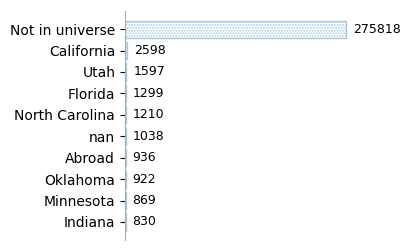

In [87]:
# 22. State of previous residence
feature_name = 'state of previous residence'
_ = describe(data[feature_name], 'cat')

In [88]:
_ = run_chi2test(data[feature_name], data[target])

target                         0   1
state of previous residence         
Abroad                       904  32
Alabama                      315   9
...                          ...  ..
Wyoming                      161   6
NaN                          333  11
--------------------
p_value = 3.28e-37 (alpha = 0.05)
cramer_v = 0.0316
`state of previous residence` and `target` are _not_ independent


We have confirmed that `state of previous residence` and target are not independent indeed, thus we will keep this feature so far.

In [89]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
38 unique
0 nulls
--------------------


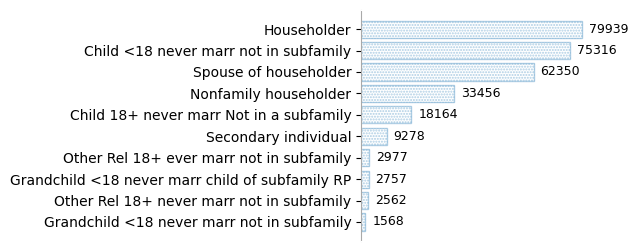

In [90]:
# 23. Detailed household and family stat
feature_name = 'detailed household and family stat'
_ = describe(data[feature_name], 'cat')

In [91]:
_ = run_chi2test(data[feature_name], data[target])

target                                      0     1
detailed household and family stat                 
Child 18+ ever marr Not in a subfamily   1441    37
Child 18+ ever marr RP of subfamily      1005    20
...                                       ...   ...
Spouse of RP of unrelated subfamily        69     7
Spouse of householder                   58922  3428
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2406
`detailed household and family stat` and `target` are _not_ independent


We have confirmed that `detailed household and family stat` and target are not independent indeed, thus we will keep this feature so far.

In [92]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
8 unique
0 nulls
--------------------


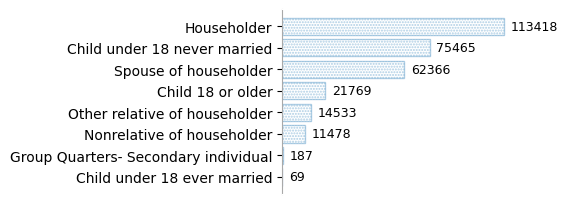

In [93]:
# 24. Detailed household summary in household
feature_name = 'detailed household summary in household'
_ = describe(data[feature_name], 'cat')

In [94]:
_ = run_chi2test(data[feature_name], data[target])

target                                       0     1
detailed household summary in household             
Child 18 or older                        21585   184
Child under 18 ever married                 69     0
...                                        ...   ...
Other relative of householder            14400   133
Spouse of householder                    58938  3428
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2267
`detailed household summary in household` and `target` are _not_ independent


We have confirmed that `detailed household summary in household` and target are not independent indeed, thus we will keep this feature so far.

In [95]:
cat_cols.append(feature_name)

Pearson corr coef = 0.03
Shape: (299285,)
Data type: float64
0 nulls
Min = 37.87
Max = 18,656.30
Mean = 1,740.10
Med = 1,617.11
Std = 994.14


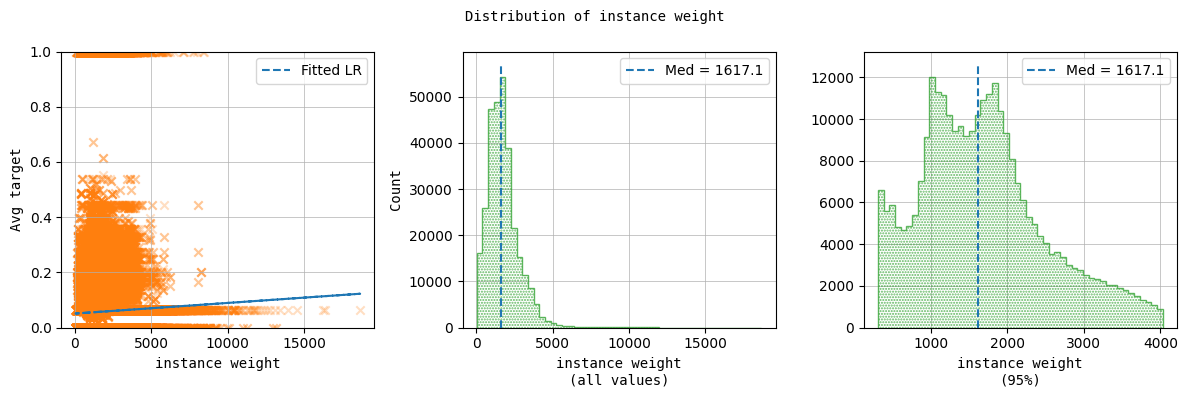

In [96]:
# 25. Instance weight
feature_name = 'instance weight'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`instance weight` looks like a continuous variable. Note that as per the description of this dataset, this variable should _not_ be used in the classifiers, thus we will drop and not use this feature in our model.

In [97]:
data.drop(columns=feature_name, inplace=True)

Shape: (299285,)
Data type: object
9 unique
149642 nulls
--------------------


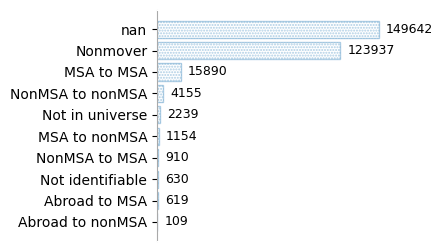

In [98]:
# 26. Migration code-change in msa
feature_name = 'migration code-change in msa'
_ = describe(data[feature_name], 'cat')

In [99]:
_ = run_chi2test(data[feature_name], data[target])

target                             0     1
migration code-change in msa              
Abroad to MSA                    595    24
Abroad to nonMSA                 107     2
...                              ...   ...
Not in universe                 2239     0
NaN                           139772  9870
--------------------
p_value = 2.06e-86 (alpha = 0.05)
cramer_v = 0.0378
`migration code-change in msa` and `target` are _not_ independent


We have confirmed that `migration code-change in msa` and target are not independent indeed, thus we will keep this feature so far. Note that this feature has around 50% of missing values.

In [100]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
8 unique
149642 nulls
--------------------


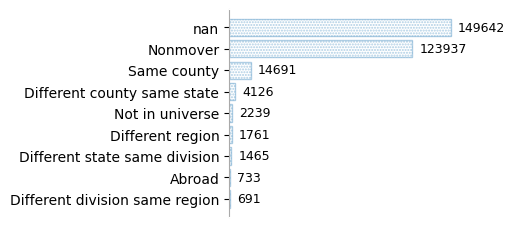

In [101]:
# 27. Migration code-change in reg
feature_name = 'migration code-change in reg'
_ = describe(data[feature_name], 'cat')

In [102]:
_ = run_chi2test(data[feature_name], data[target])

target                             0     1
migration code-change in reg              
Abroad                           707    26
Different county same state     3924   202
...                              ...   ...
Same county                    14185   506
NaN                           139772  9870
--------------------
p_value = 3.85e-83 (alpha = 0.05)
cramer_v = 0.0369
`migration code-change in reg` and `target` are _not_ independent


We have confirmed that `migration code-change in reg` and target are not independent indeed, thus we will keep this feature so far. Note that this variable has around 50% of missing values.

In [103]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
9 unique
149642 nulls
--------------------


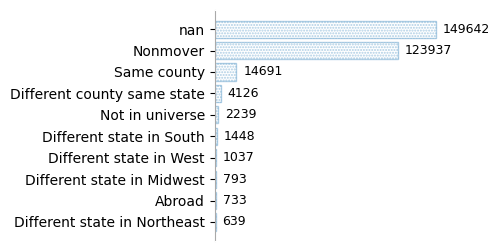

In [104]:
# 28. Migration code-move within reg
feature_name = 'migration code-move within reg'
_ = describe(data[feature_name], 'cat')

In [105]:
_ = run_chi2test(data[feature_name], data[target])

target                               0     1
migration code-move within reg              
Abroad                             707    26
Different county same state       3924   202
...                                ...   ...
Same county                      14185   506
NaN                             139772  9870
--------------------
p_value = 1.34e-83 (alpha = 0.05)
cramer_v = 0.0372
`migration code-move within reg` and `target` are _not_ independent


We have confirmed that `migration code-move within reg` and target are not independent indeed, thus we will keep this feature so far. Note that this feature has around 50% of missing values.

In [106]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


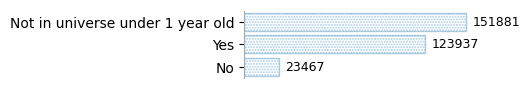

In [107]:
# 29. Live in this house 1 year ago
feature_name = 'live in this house 1 year ago'
_ = describe(data[feature_name], 'cat')

In [108]:
_ = run_chi2test(data[feature_name], data[target])

target                                 0     1
live in this house 1 year ago                 
No                                 22520   947
Not in universe under 1 year old  142011  9870
Yes                               116186  7751
--------------------
p_value = 6.15e-47 (alpha = 0.05)
cramer_v = 0.0267
`live in this house 1 year ago` and `target` are _not_ independent


We have confirmed that `live in this house 1 year ago` and target are not independent indeed, thus we will keep this feature so far.

In [109]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
3 unique
149642 nulls
--------------------


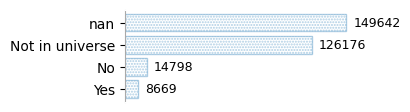

In [110]:
# 30. Migration prev res in sunbelt
feature_name = 'migration prev res in sunbelt'
_ = describe(data[feature_name], 'cat')

In [111]:
_ = run_chi2test(data[feature_name], data[target])

target                              0     1
migration prev res in sunbelt              
No                              14146   652
Not in universe                118425  7751
Yes                            139772  9870
NaN                              8374   295
--------------------
p_value = 1.31e-51 (alpha = 0.05)
cramer_v = 0.0283
`migration prev res in sunbelt` and `target` are _not_ independent


We have confirmed that `migration prev res in sunbelt` and target are not independent indeed, thus we will keep this feature so far. Note that this variable has around 50% of missing values.

In [112]:
cat_cols.append(feature_name)

Pearson corr coef = 0.94
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 6.00
Mean = 1.96
Med = 1.00
Std = 2.36


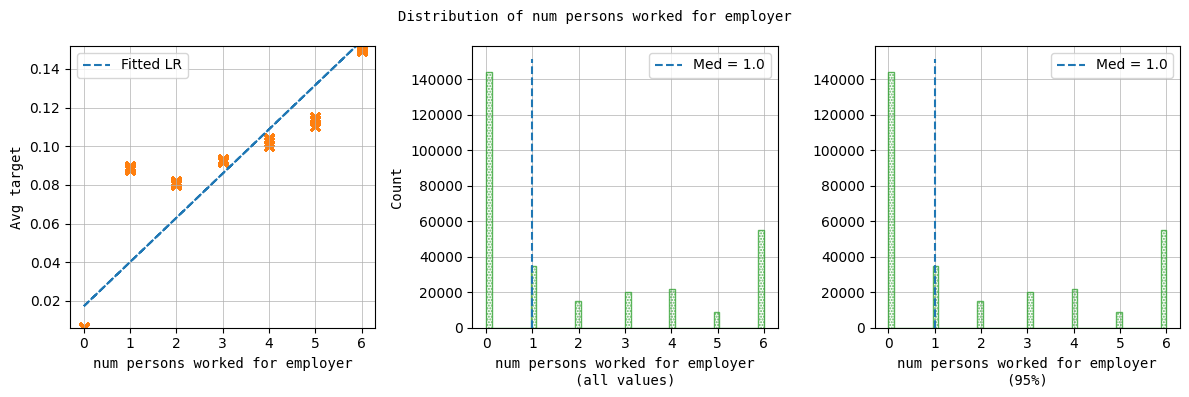

In [113]:
# 31. Num persons worked for employer
feature_name = 'num persons worked for employer'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`num persons worked for employer` looks like a continuous variable but with few unique integer values. It looks to be strongly correlated with the target (linearly). Since it has a countable number of values (like categories), we can also check if it is associated with the target.

Shape: (299285,)
Data type: int64
7 unique
0 nulls
--------------------


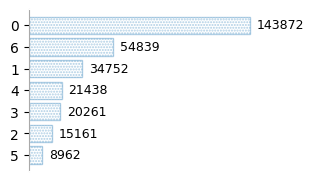

In [114]:
_ = describe(data[feature_name], 'cat')

In [115]:
_ = run_chi2test(data[feature_name], data[target])

target                                0     1
num persons worked for employer              
0                                142966   906
1                                 31666  3086
...                                 ...   ...
5                                  7954  1008
6                                 46574  8265
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2379
`num persons worked for employer` and `target` are _not_ independent


We have confirmed that `num persons worked for employer` and target are not independent indeed, thus we will keep this feature so far.

In [116]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: object
5 unique
0 nulls
--------------------


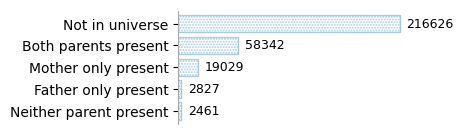

In [117]:
# 32. Family members under 18
feature_name = 'family members under 18'
_ = describe(data[feature_name], 'cat')

In [118]:
_ = run_chi2test(data[feature_name], data[target])

target                        0      1
family members under 18               
Both parents present      58340      2
Father only present        2827      0
Mother only present       19029      0
Neither parent present     2461      0
Not in universe          198060  18566
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1588
`family members under 18` and `target` are _not_ independent


We have confirmed that `family members under 18` and target are not independent indeed, thus we will keep this feature so far.

In [119]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
42 unique
10142 nulls
--------------------


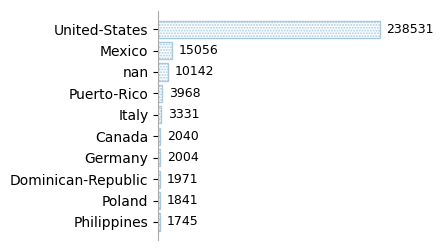

In [120]:
# 33. Country of birth father
feature_name = 'country of birth father'
_ = describe(data[feature_name], 'cat')

In [121]:
_ = run_chi2test(data[feature_name], data[target])

target                      0    1
country of birth father           
Cambodia                  306    7
Canada                   1848  192
...                       ...  ...
Yugoslavia                661   14
NaN                       319   21
--------------------
p_value = 3.20e-295 (alpha = 0.05)
cramer_v = 0.0717
`country of birth father` and `target` are _not_ independent


We have confirmed that `country of birth father` and target are not independent indeed, thus we will keep this feature so far.

In [122]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
42 unique
9191 nulls
--------------------


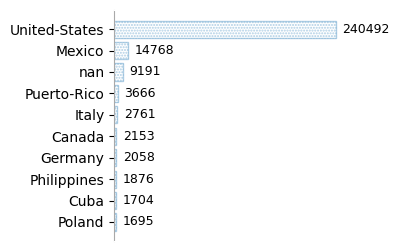

In [123]:
# 34. Country of birth mother
feature_name = 'country of birth mother'
_ = describe(data[feature_name], 'cat')

In [124]:
_ = run_chi2test(data[feature_name], data[target])

target                      0    1
country of birth mother           
Cambodia                  250    8
Canada                   1943  210
...                       ...  ...
Yugoslavia                696   14
NaN                       266   13
--------------------
p_value = 1.41e-285 (alpha = 0.05)
cramer_v = 0.0706
`country of birth mother` and `target` are _not_ independent


We have confirmed that `country of birth mother` and target are not independent indeed, thus we will keep this feature so far.

In [125]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
42 unique
5157 nulls
--------------------


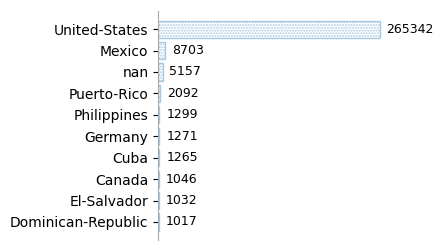

In [126]:
# 35. Country of birth self
feature_name = 'country of birth self'
_ = describe(data[feature_name], 'cat')

In [127]:
_ = run_chi2test(data[feature_name], data[target])

target                   0    1
country of birth self          
Cambodia               156    2
Canada                 943  103
...                    ...  ...
Yugoslavia             559   14
NaN                    108    6
--------------------
p_value = 5.63e-197 (alpha = 0.05)
cramer_v = 0.0598
`country of birth self` and `target` are _not_ independent


We have confirmed that `country of birth self` and target are not independent indeed, thus we will keep this feature so far.

In [128]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
5 unique
0 nulls
--------------------


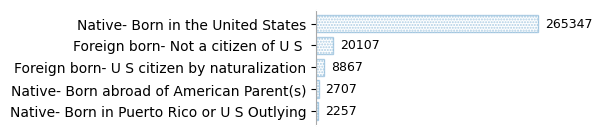

In [129]:
# 36. Citizenship
feature_name = 'citizenship'
_ = describe(data[feature_name], 'cat')

In [130]:
_ = run_chi2test(data[feature_name], data[target])

target                                            0      1
citizenship                                               
Foreign born- Not a citizen of U S            19386    721
Foreign born- U S citizen by naturalization    7968    899
Native- Born abroad of American Parent(s)      2521    186
Native- Born in Puerto Rico or U S Outlying    2204     53
Native- Born in the United States            248638  16709
--------------------
p_value = 8.78e-115 (alpha = 0.05)
cramer_v = 0.0423
`citizenship` and `target` are _not_ independent


We have confirmed that `citizenship` and target are not independent indeed, thus we will keep this feature so far.

In [131]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: int64
3 unique
0 nulls
--------------------


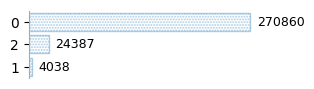

In [132]:
# 37. Own business or self employed
feature_name = 'own business or self employed'
_ = describe(data[feature_name], 'cat')

In [133]:
_ = run_chi2test(data[feature_name], data[target])

target                              0      1
own business or self employed               
0                              255205  15655
1                                3145    893
2                               22367   2020
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.0822
`own business or self employed` and `target` are _not_ independent


We have confirmed that `own business or self employed` and target are not independent indeed, thus we will keep this feature so far.

In [134]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


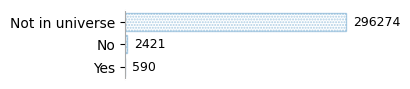

In [135]:
# 38. Fill inc questionnaire for veteran admin
feature_name = 'fill inc questionnaire for veteran admin'
_ = describe(data[feature_name], 'cat')

In [136]:
_ = run_chi2test(data[feature_name], data[target])

target                                         0      1
fill inc questionnaire for veteran admin               
No                                          2090    331
Not in universe                           278061  18213
Yes                                          566     24
--------------------
p_value = 1.80e-52 (alpha = 0.05)
cramer_v = 0.0282
`fill inc questionnaire for veteran admin` and `target` are _not_ independent


We have confirmed that `fill inc questionnaire for veteran admin` and target are not independent indeed, thus we will keep this feature so far.

In [137]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: int64
3 unique
0 nulls
--------------------


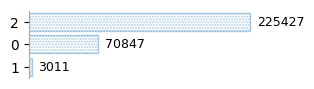

In [138]:
# 39. Veterans benefits
feature_name = 'veterans benefits'
_ = describe(data[feature_name], 'cat')

In [139]:
_ = run_chi2test(data[feature_name], data[target])

target                  0      1
veterans benefits               
0                   70847      0
1                    2656    355
2                  207214  18213
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1440
`veterans benefits` and `target` are _not_ independent


We have confirmed that `veterans benefits` and target are not independent indeed, thus we will keep this feature so far.

In [140]:
cat_cols.append(feature_name)

Pearson corr coef = 0.96
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 52.00
Mean = 23.18
Med = 8.00
Std = 24.40


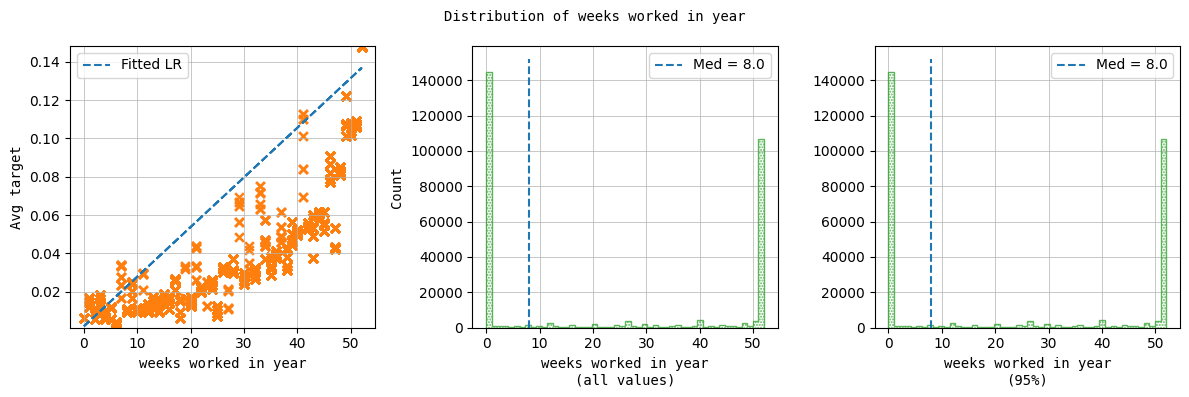

In [141]:
# 40. Weeks worked in year
feature_name = 'weeks worked in year'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
53 unique
0 nulls
--------------------


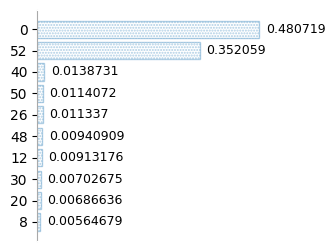

In [142]:
_ = describe(data[feature_name], 'cat', normalize=True)

`weeks worked in year` looks like a continuous variable. It looks to be strongly correlated with the target (linearly). It is mostly takes the values of 0 and 52 weeks. Looks like, those who work more weeks, earn more too. We will keep this feature so far.

In [143]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: int64
2 unique
0 nulls
--------------------


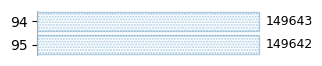

In [144]:
# 41. Year
feature_name = 'year'
_ = describe(data[feature_name], 'cat')

In [145]:
_ = run_chi2test(data[feature_name], data[target])

target       0     1
year                
94      140945  8698
95      139772  9870
--------------------
p_value = 7.07e-19 (alpha = 0.05)
cramer_v = 0.0162
`year` and `target` are _not_ independent


`year` looks like an ordinal/categorical variable which is associated with the target, thus we will keep this feature so far.

In [146]:
cat_cols.append(feature_name)

In [147]:
# EDA done for all features?
len(num_cols) + len(cat_cols) == data.drop(columns=target).shape[1]

False

In [148]:
# Number of features kept so far
print(f'{len(num_cols) = }')
print(f'{len(cat_cols) = }')

len(num_cols) = 6
len(cat_cols) = 33


We have kept 6 out of 7 numerical features. Let's see if we can reduce this number with PCA for 2 components.

In [149]:
pca = PCA(n_components=2, random_state=seed)
num_2d_pc = pca.fit_transform(data[num_cols])
data['pc_1'], data['pc_2'] = num_2d_pc[:, 0], num_2d_pc[:, 1]

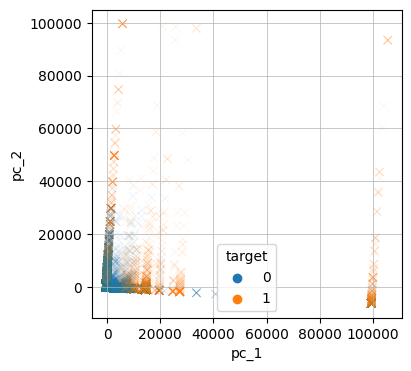

In [150]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data, x='pc_1', y='pc_2', hue=target, marker='x', alpha=0.1)
plt.grid(lw=0.5);

It looks like the new discovered components can distinguish between the target classes to some degree. Now, let's see if our numerical features, including the new 2 components, correlate between each other (Pearson).

In [151]:
(data[num_cols + ['pc_1', 'pc_2']].corr().replace(1.0, np.nan)
 .style
    .set_caption("<h4>Numerical features correlation matrix (Pearson)</h4>")
    .format(formatter=lambda x: f'{x:.2f}', na_rep='-')
    .highlight_between(
        left=0.5,
        right=1.0,
        color='pink')
        #props='background-color:rgb(144, 238, 144, 0.2);') # green
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
)

,age,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,pc_1,pc_2
age,-,0.05,0.06,0.11,0.14,0.20,0.06,0.10
capital gains,0.05,-,-0.01,0.13,0.06,0.08,1.00,-0.03
capital losses,0.06,-0.01,-,0.04,0.08,0.10,-0.01,0.05
dividends from stocks,0.11,0.13,0.04,-,0.01,0.01,0.15,0.99
num persons worked for employer,0.14,0.06,0.08,0.01,-,0.75,0.06,-0.00
weeks worked in year,0.20,0.08,0.10,0.01,0.75,-,0.08,0.00
pc_1,0.06,1.00,-0.01,0.15,0.06,0.08,-,-0.00
pc_2,0.10,-0.03,0.05,0.99,-0.00,0.00,-0.00,-


We can see that the new feature `pc_1` is strongly linearly correlated with `capital gains` and `pc_2` with `dividends from stocks`, that is adding these two new features does not add new information but only creates colinear covariates, so we will not include new components in our model. At the same time, keeping only these two components will lose information from other features, and the model might underfit. We have only 6 numerical features, so it doesn't look like a dimensionality problem.

 `num persons worked for employer` and `weeks worked in year` look to be correlated. Over 83% of `weeks worked in year` take only two values: 0 and 52, while `num persons worked for employer` variates more, so it's tempting to get rid of the former one. However, let's still keep both for now.

In [152]:
# Final list of numerical features
num_cols

['age',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'num persons worked for employer',
 'weeks worked in year']

In [153]:
# Num feature-target correlation
feat_target_corr = pd.DataFrame(columns=['num_feature', 'target'])
for num_col in num_cols:
    feature_encoded = feat_eng_target_enc.fit_transform(data[num_col].values.reshape(-1, 1), data[target])
    r = data[num_col].corr(pd.Series(feature_encoded.flatten()))
    feat_target_corr.loc[len(feat_target_corr)] = [num_col, r]

In [154]:
(feat_target_corr.set_index('num_feature')
 .style
    .set_caption("<h4>Numerical features and target correlation matrix (Pearson)</h4>")
    .format(formatter=lambda x: f'{x:.2f}', na_rep='-')
    .highlight_between(
        left=0.5,
        right=1.0,
        color='pink')
        #props='background-color:rgb(144, 238, 144, 0.2);') # green
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
)

,target
num_feature,
age,0.54
capital gains,0.65
capital losses,0.59
dividends from stocks,0.51
num persons worked for employer,0.94
weeks worked in year,0.96


Next, we have kept all 33 categorical/ordinal features so far. Let's examine association between them and the target using the Cramer's V metric. We do not use $p$-values for decision-making, because it is not obvious how to weigh them, since they have only one cut-off value at the significance level $\alpha$. Therefore, Cramer's V looks more informative. Tschuprow's T statistic might also be used here.

In [155]:
# Build all categorical/ordinal/target columns associations crosstab
assoc_tab = build_assoc_tab(data, cat_cols + [target])

In [156]:
# Take a look at some 5 random associations
assoc_tab.iloc[sorted(np.random.choice(assoc_tab.shape[0], 5, replace=False))]

,X_1,X_2,p_value,cramer_v
136,enroll in edu inst last wk,region of previous residence,8.606836e-58,0.022256
216,major occupation code,tax filer stat,0.000000e+00,0.338870
233,major occupation code,veterans benefits,0.000000e+00,0.392560
286,sex,reason for unemployment,7.519105e-143,0.047364
447,detailed household summary in household,country of birth father,0.000000e+00,0.068630


In [157]:
cat_excl_cols = []

In [158]:
# Feature-feature associations
# Do not show target
_ = assoc_tab.loc[lambda x: (x['X_1'] != 'target') & (x['X_2'] != 'target')]
# Exclude `X_2` features with very strong association with `X_1` features (pairs)
# Reference Cramers' V values: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v
cat_excl_cols.extend(set(_.loc[lambda x: x['cramer_v'] >= 0.8]['X_2'].values))
#cat_excl_cols

In [159]:
# Feature-target associations
# Show only target
_ = assoc_tab.loc[lambda x: (x['X_1'] == 'target') | (x['X_2'] == 'target')]
# Exclude features weakly correlated with the target
cat_excl_cols.extend(set(_.loc[lambda x: x['cramer_v'] < 0.1]['X_1'].values))
#cat_excl_cols

In [160]:
# Final list of categorical features
cat_cols = list(set(cat_cols) - set(cat_excl_cols))
cat_cols

['detailed industry recode',
 'detailed occupation recode',
 'family members under 18',
 'detailed household and family stat',
 'class of worker',
 'veterans benefits',
 'tax filer stat',
 'sex',
 'full or part time employment stat',
 'marital stat',
 'education']

In [161]:
# Check
_ = build_assoc_tab(data, cat_cols + [target]).pivot_table(values='cramer_v', index='X_1', columns='X_2', margins=True)

In [162]:
(_.sort_values(by='All', axis=0, ascending=False).sort_values(by='All', axis=1, ascending=False).drop('All', axis=0).drop('All', axis=1)
.style
    .set_caption("<h4>Features and target association matrix (Cramer's V)</h4>")
    .format(formatter=lambda x: f'{x:.2f}', na_rep='-')
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
    .applymap(lambda x: 'background-color: lightgreen', subset='target')
)

X_2,veterans benefits,detailed occupation recode,tax filer stat,class of worker,detailed household and family stat,education,marital stat,family members under 18,target,full or part time employment stat,sex
X_1,,,,,,,,,,,
education,-,-,-,-,-,-,-,-,0.39,-,-
veterans benefits,-,-,0.51,-,-,0.71,0.45,-,0.14,0.31,0.07
detailed household and family stat,0.63,-,0.53,0.21,-,0.24,0.48,-,0.24,0.16,0.41
family members under 18,0.63,-,0.38,0.28,0.72,0.46,0.35,-,0.16,0.20,0.04
detailed occupation recode,0.39,-,0.34,0.46,0.11,0.28,0.19,0.28,0.44,0.24,0.39
detailed industry recode,0.39,0.42,0.34,0.51,0.10,0.19,0.18,0.28,0.29,0.24,0.31
tax filer stat,-,-,-,-,-,0.35,0.47,-,0.23,0.21,0.12
class of worker,0.39,-,0.34,-,-,0.24,0.18,-,0.26,0.25,0.13
marital stat,-,-,-,-,-,0.28,-,-,0.20,-,-


Now we can confirm that we excluded strongly associated features between each other ($v > 0.8$), while keeping at least some association with the target ($v \ge 0.1$). In the matrix above, "-" means not calculated value, since we used combinations (not permutations) to exclude duplicates and thus speed up, so such values can be found in the corresponding pairs.

Note, that this selection might not be optimal, since we only used the Cramer's V statistic for decision-making without any sorting or other preference between the features. It might be useful to choose the feature that variates more in every pair, like we did with two numerical features above; or compare their association with the target and keep the most associated one in every pair. There is always room for optimization, but it takes time.

Also, for simplicity, we did not check any measure of dependence between numerical and categorical features. This might be done visually using box plots, for example, with distinct categories of a categorical feature on the x-axis and the distribution of a numerical feature on the y-axis. See an example below for age vs education dependence. Males are a bit younger than females on average, but in fact there is no strong dependence, so we can keep both features.

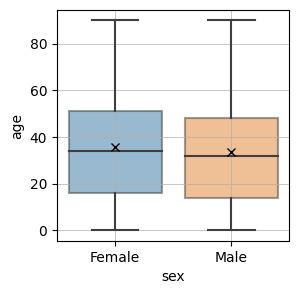

In [163]:
plt.figure(figsize=(3, 3))
sns.boxplot(data=data[['age', 'sex']].sort_values(by='sex'), x='sex', y='age', flierprops={'marker': 'o', 'markersize': 4}, showmeans=True, meanprops={'marker': 'x', 'markeredgecolor': 'k', 'markerfacecolor': 'k', 'markersize': 6}, boxprops=dict(alpha=0.5))
plt.grid(lw=0.5);

### <a id="data-preprocessing"></a>[25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)

In [164]:
# Check nulls
data[num_cols + cat_cols + [target]].isna().sum()

age                                   0
capital gains                         0
capital losses                        0
dividends from stocks                 0
num persons worked for employer       0
weeks worked in year                  0
detailed industry recode              0
detailed occupation recode            0
family members under 18               0
detailed household and family stat    0
class of worker                       0
veterans benefits                     0
tax filer stat                        0
sex                                   0
full or part time employment stat     0
marital stat                          0
education                             0
target                                0
dtype: int64

We can see that our data with finally selected features and target does not have missing values, but it is not guaranteed that there will be no missing values in the test data, so we will use imputers both for numerical and categorical features.
- for numerical features, we will impute with the median, since it is a good statistic for non-normal skewed distributions;
- for categorical features, we will impute with a constant value 'Unknown', since this value looks reasonable and it does not mutate the original distribution.

In [165]:
# Confirm that the 'Unknown' value is not used and thus we can safely use it for imputing
'Unknown' in data[cat_cols].values

False

In [166]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding

In [167]:
# Check categorical features cardinality
data[cat_cols].nunique().sort_values(ascending=False)

detailed industry recode              52
detailed occupation recode            47
detailed household and family stat    38
education                             17
class of worker                        9
full or part time employment stat      8
marital stat                           7
tax filer stat                         6
family members under 18                5
veterans benefits                      3
sex                                    2
dtype: int64

<a id="encoding"></a>We will not use one-hot encoding in this task, since several features have high cardinality, and we wouldn't like a too complex model, which is slow to train and subject to overfitting. In general, feature encoding depends on the model to be used. Consider several classification models:
- Linear models:
1. Logistic Regression needs encoding. Weight of Evidence encoding (WoE) was designed for binary classification. It can be shown that the logit function (result of WoE encoding) is equivalent to the linear regression expression, so it looks to be the proper choice;
2. Linear SVC (Support Vector Machine) needs encoding. Same as above; 
- Decision Tree-based models:
3. Random Forest (there's an initiative in sklearn to introduce native support of categorical features) can use ordinal or target-based encoding, preferably with no leakage;
4. XGBoost can use ordinal encoding (pandas category data type), as per documentation, or target-based, preferably with no leakage;
5. LightGBM can use integer-encoding, as per documentation, or target-based, preferably with no leakage;
6. CatBoost natively supports categorical features with built-in CatBoost encoding (target-based with no leakage).

For numerical features for linear algorithms we will also apply standard scaling, since we need to make sure that features (and thus weights) are neither too small, nor too large, so that no feature vanishes or explodes; for decision tree-based algorithms this should not be an issue, so scaling is possible, but not necessary.

In [168]:
num_lm_encoder = StandardScaler()
cat_lm_encoder = WOEEncoder(random_state=seed)
#num_dt_encoder = StandardScaler() # no need
cat_dt_encoder = CatBoostEncoder(random_state=seed)

Now we can construct column transformers tailored to models and feature types.

In [169]:
# Linear models
column_transformer_lm = ColumnTransformer([
                                            ('num_cols', make_pipeline(num_imputer, num_lm_encoder), num_cols), 
                                            ('cat_cols', make_pipeline(cat_imputer, cat_lm_encoder), cat_cols)
                                            ], n_jobs=-1)
# Decision Tree-based models
column_transformer_dt = ColumnTransformer([
                                            ('num_cols', make_pipeline(num_imputer), num_cols), 
                                            ('cat_cols', make_pipeline(cat_imputer, cat_dt_encoder), cat_cols)
                                            ], n_jobs=-1)

In [170]:
# Check, if column transformers work
column_transformer_lm.fit_transform(data[num_cols + cat_cols], data[target])[:1], column_transformer_dt.fit_transform(data[num_cols + cat_cols], data[target])[:1]

(array([[ 1.72328432, -0.09243509, -0.13658439, -0.10106658, -0.82718558,
         -0.94977869, -1.99068692, -1.99068692,  0.34861754, -1.80700029,
         -1.98787383,  0.28424042, -4.98230244, -0.9282956 , -1.30188048,
         -0.66600021, -0.47243045]]),
 array([[7.30000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 6.20411982e-02, 6.20411982e-02,
         6.20411982e-02, 6.20411982e-02, 6.20411982e-02, 6.20411982e-02,
         6.20411982e-02, 6.20411982e-02, 6.20411982e-02, 6.20411982e-02,
         6.20411982e-02]]))

* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

We'll use K-Means clustering algorithm for numerical features. For the categorical features clustering algorithms like K-Means or DBSCAN are not applicable, since they use distance metrics, and it's not clear what distance is between, for example, levels of education or marital statuses. To assess the quality of clustering we'll look at two metrics:
- Inertia (within-cluster sum-of-squares) — the lower the better. Inertia decreases as the number of clusters increases. The optimal value is 0.0;
- Silhouette Score (SS) (mean intra-cluster distance) — the lower the better. SS also decreases as the number of clusters increases. The optimal value is 1.0.

The idea is to find the number of clusters such that Inertia is minimized while SS is maximized at the same: $k_{opt} = \underset{k}{\argmax}(|SS - Inertia|)$.

In [171]:
# Computing silhouette_score in sklearn may take much time, 
# so we'll take a small portion of all observations at this stage, 
# but will use the whole data for final clustering, after deciding on the number of clusters.
mean_inertias, mean_ss, n_clusters = [], [], []
for k in range(2, 11):
    inertias, ss = [], []
    #print(k)
    n_clusters.append(k)
    model_kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    for _ in range(50): # Bootstrap metrics
        idx = np.random.choice(data.shape[0], int(0.01 * data.shape[0]), replace=False)
        labels = model_kmeans.fit(data[num_cols].values[idx]).labels_
        inertias.append(model_kmeans.inertia_)
        ss.append(silhouette_score(data[num_cols].values[idx], labels))
    mean_inertias.append(np.mean(inertias))
    mean_ss.append(np.mean(ss))

In [172]:
# Inertia and SS are functions of different order, transform them first into [0, 1] codomain, so that we can compare them
inertias_rescaled = MinMaxScaler().fit_transform(np.array(mean_inertias).reshape(-1, 1))
ss_rescaled = MinMaxScaler().fit_transform(np.array(mean_ss).reshape(-1, 1))
k_opt = np.abs(inertias_rescaled - ss_rescaled).argmax() + 2
print(f'Optimal number of clusters: {k_opt}')

Optimal number of clusters: 6


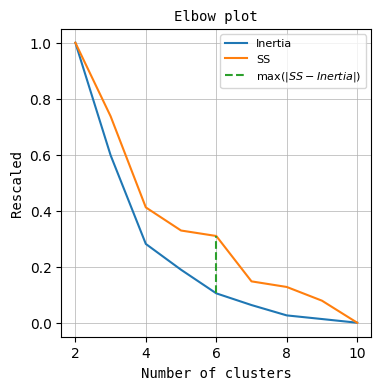

In [173]:
# Elbow plot
plt.figure(figsize=(4, 4))
plt.plot(n_clusters, inertias_rescaled, color='C0', label='Inertia')
plt.plot(n_clusters, ss_rescaled, color='C1', label='SS')
plt.plot([k_opt, k_opt], [inertias_rescaled[k_opt-2], ss_rescaled[k_opt-2]], ls='--', color='C2', label='$\max(|SS-Inertia|)$')
plt.xlabel('Number of clusters', size=10, family='monospace')
plt.ylabel('Rescaled', size=10, family='monospace')
plt.legend(fontsize=8)
plt.title('Elbow plot', size=10, family='monospace')
plt.grid(lw=0.5);

So, after simultaneously minimizing Inertia and maximizing the Silhouette Score, $k_{opt} \in [4, 6]$.

Recall the [plot](#feature-age) of average target vs `age` — it looks like we can bin the age at least into 3 groups: young, middle-aged, and elderly participants. Let's see what K-Means can discover for us with 6 clusters.

Pearson corr coef = 0.54
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 90.00
Mean = 34.54
Med = 33.00
Std = 22.32


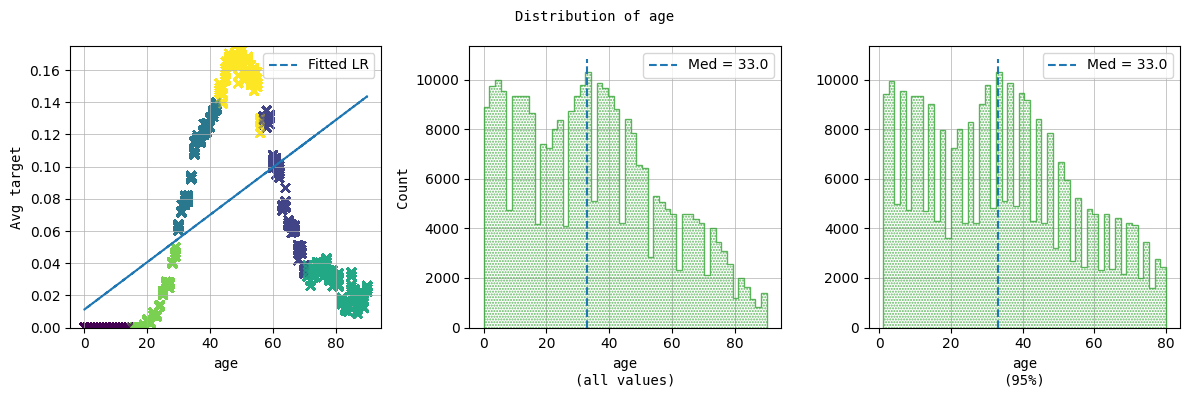

In [174]:
# Age with 6 clusters
labels = KMeans(n_clusters=6, n_init='auto', random_state=seed).fit(data['age'].values.reshape(-1, 1)).labels_
feature_encoded = feat_eng_target_enc.fit_transform(data['age'].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data['age'].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data['age'], 'num')
plot_hist(data['age'].values, feature_encoded, 50, 95, 'age', 'Distribution of age', labels)

Great! Let's add the cluster number as a new feature and check age ranges for each cluster (group).

In [175]:
data['group'] = 'Group_'
data['group'] = data['group'] + labels.astype(str)

In [176]:
data.groupby('group')['age'].apply(lambda x: f'{x.min()} -- {x.max()}').sort_values()

group
Group_0     0 -- 14
Group_4    15 -- 29
Group_2    30 -- 42
Group_5    43 -- 56
Group_1    57 -- 70
Group_3    71 -- 90
Name: age, dtype: object

This grouping makes sense: children or school students most likely without professional education (0 — 14), so they are not likely to earn much if at all; then go college students and young professionals (15 — 29), professionals (30 — 42), then seasoned professionals and managers (43 — 56) who are more likely to earn more than the other groups, then finishing their career (57 — 70), and finally retired (71 — 90).

In [177]:
cat_cols.append('group')

Final features set (6 num + 12 cat):

|  n | Feature                              | Type |
|---:|--------------------------------------|------|
|  1 | `age`                                | Num  |
|  2 | `capital gains`                      | Num  |
|  3 | `capital losses`                     | Num  |
|  4 | `dividends from stocks`              | Num  |
|  5 | `num persons worked for employer`    | Num  |
|  6 | `weeks worked in year`               | Num  |
|  7 | `class of worker`                    | Cat  |
|  8 | `detailed household and family stat` | Cat  |
|  9 | `detailed industry recode`           | Cat  |
| 10 | `detailed occupation recode`         | Cat  |
| 11 | `education`                          | Cat  |
| 12 | `family members under 18`            | Cat  |
| 13 | `full or part time employment stat`  | Cat  |
| 14 | `group` (added cluster)              | Cat  |
| 15 | `marital stat`                       | Cat  |
| 16 | `sex`                                | Cat  |
| 17 | `tax filer stat`                     | Cat  |
| 18 | `veterans benefits`                  | Cat  |

### <a id="model-training"></a>[25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)

We can assume that our data is naturally imbalanced — common sense tells use that it is quite expected that there are more individuals who earn less than those who earn more. So we will assume this imbalance is not caused by some incorrect sampling or other bias. Reducing imbalance might help prevent our model from becoming biased towards majority class. In other words, the model will no longer learn only the majority class observations just because they are more frequent. Note that this is only used to train models. It does not make any sense to re-balance our test data, since the imbalance is natural and real data, fed into models, will always be imbalanced, so the classifier has to learn to work well on real _imbalanced_ data. There are several techniques to combat imbalance:
- classifier built-in mechanism tuned by parameters such as `class_weight` — assigned different weights to the majority and minority class observations;
- undersampling — drop some observations from the majority class:
    - NearMiss;
    - Tomek's links;
    - Random;
- oversampling — add new observations to the minority class:
    - SMOTE / Borderline SMOTE;
    - ADASYN;
    - Random;
- combined under- and oversampling:
    - SMOTE + Tomek's links.

First we'll make the train-val-test split. Don't forget to check that the split and stratification are done correctly.

In [178]:
train, test = train_test_split(data[num_cols + cat_cols + [target]], test_size=0.2, stratify=data[target], random_state=seed)
train, val = train_test_split(train, test_size=0.125, stratify=train[target], random_state=seed)

In [179]:
# Run some split checks
(
    np.allclose(train.shape[0] / data.shape[0], 0.7, atol=1e-6),
    np.allclose(val.shape[0] / data.shape[0], 0.1, atol=1e-6),
    np.allclose(test.shape[0] / data.shape[0], 0.2, atol=1e-6)
)

(True, True, True)

Shape: (209499,)
Data type: int32
2 unique
0 nulls
--------------------


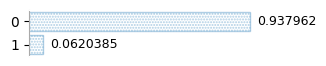

In [180]:
_ = describe(train[target], 'cat', normalize=True)

Shape: (29929,)
Data type: int32
2 unique
0 nulls
--------------------


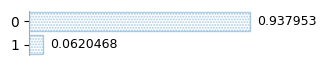

In [181]:
_ = describe(val[target], 'cat', normalize=True)

Shape: (59857,)
Data type: int32
2 unique
0 nulls
--------------------


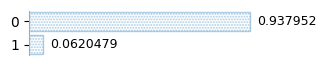

In [182]:
_ = describe(test[target], 'cat', normalize=True)

In [183]:
(
    (train.columns == num_cols + cat_cols + [target]).all(),
    (val.columns == num_cols + cat_cols + [target]).all(), 
    (test.columns == num_cols + cat_cols + [target]).all()
)

(True, True, True)

In [184]:
# Split features and target
y_train = train[target]
y_val = val[target]
y_test = test[target]
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns=target)

In [185]:
(
    (X_train.shape, y_train.shape),
    (X_val.shape, y_val.shape), 
    (X_test.shape, y_test.shape)
)

(((209499, 18), (209499,)), ((29929, 18), (29929,)), ((59857, 18), (59857,)))

Let's use Logistic Regression as our baseline model to evaluate different class balancing techniques. We'll use precision, recall, and $F_{1}$-score as the evaluation metrics. We'll use cross-validation on `X_val` (smallest dataset) to speed up, since this is a rough assessment of balancers.

In [186]:
model_for_balancers = LogisticRegression(random_state=seed, n_jobs=-1)
balancers_to_eval = [{'name': 'None', 'balancer': None},
                     {'name': 'Class-weight', 'balancer': None},
                     {'name': 'RandUnder', 'balancer': RandomUnderSampler(sampling_strategy=0.1, random_state=seed)},
                     {'name': 'NearMiss', 'balancer': NearMiss()},
                     {'name': 'TomekLinks', 'balancer': TomekLinks()},
                     {'name': 'RandOver', 'balancer': RandomOverSampler(random_state=seed)},
                     {'name': 'SMOTE', 'balancer': SMOTE(random_state=seed)},
                     {'name': 'BorderlineSMOTE', 'balancer': BorderlineSMOTE(random_state=seed)},
                     {'name': 'ADASYN', 'balancer': ADASYN(random_state=seed)},
                     {'name': 'SMOTETomek', 'balancer': SMOTETomek(random_state=seed)}
                  ]

In [187]:
print('Balancer:')
for balancer_to_eval in balancers_to_eval:
    if balancer_to_eval['name'] == 'Class-weight':
        model = model_for_balancers.set_params(class_weight='balanced')    
    else:
        model = model_for_balancers
    pipe = make_pipeline(column_transformer_lm, balancer_to_eval['balancer'], model)
    metrics = cross_validate(pipe, X_val, y_val, scoring=['precision', 'recall', 'f1'], cv=5, n_jobs=-1)
    balancer_to_eval['mean_precision'] = metrics['test_precision'].mean()
    balancer_to_eval['mean_recall'] = metrics['test_recall'].mean()
    balancer_to_eval['mean_f1'] = metrics['test_f1'].mean()
    print(f"{balancer_to_eval['name']:<15} ({metrics['fit_time'].mean()+metrics['score_time'].mean():.2f}s)")

Balancer:


None            (0.93s)
Class-weight    (0.88s)
RandUnder       (0.86s)
NearMiss        (1.17s)
TomekLinks      (3.02s)
RandOver        (0.72s)
SMOTE           (0.78s)
BorderlineSMOTE (1.10s)
ADASYN          (1.33s)
SMOTETomek      (10.61s)


In [188]:
pd.DataFrame(balancers_to_eval).drop(columns='balancer')

,name,mean_precision,mean_recall,mean_f1
0,None,0.718400,0.374789,0.492243
1,Class-weight,0.278551,0.896061,0.424968
2,RandUnder,0.277892,0.896061,0.424204
3,NearMiss,0.120762,0.694128,0.203764
4,TomekLinks,0.274343,0.897138,0.420171
5,RandOver,0.278330,0.895522,0.424650
6,SMOTE,0.283315,0.889057,0.429664
7,BorderlineSMOTE,0.277952,0.889595,0.423443
8,ADASYN,0.241358,0.921372,0.382490
9,SMOTETomek,0.283315,0.889057,0.429664


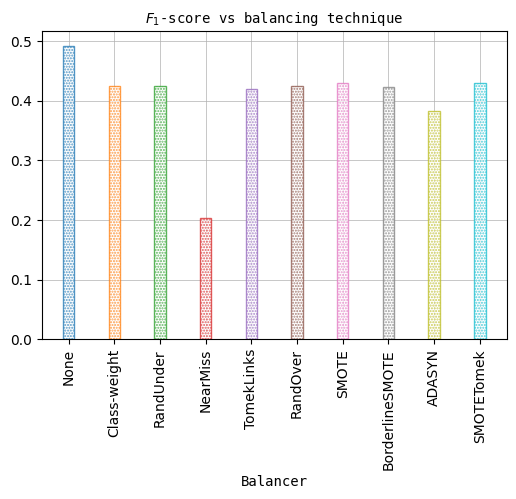

In [287]:
plot_bar(pd.DataFrame(balancers_to_eval), 'name', 'mean_f1', 'Balancer', '$F_{1}$-score vs balancing technique', rot=90)

We can see that balancing does not help improve our model (Logistic Regression classifier in this case), rather it only can "switch" precision and recall. $F_{1}$-score is even better without balancing. So, it looks like balancing cannot help improve our classifier this time. Balancing does not provide the classifier with more information, it just presents it in a different way in order to force the classifier to pay more attention to the minority class. Balancing cannot automatically improve the quality of a classifier. Recall the naive classifier: can balancing make it a better one? Obviously, it cannot.

Right now, our classifier can only do one job at a time: either have higher precision (fewer type I errors) with no balancing, or higher recall (fewer type II errors) with balancing, but not both. Let's plot precision and recall vs the probability thresholds (decision boundaries) to show it. As with evaluating balancers, we'll use `X_val` to speed up.

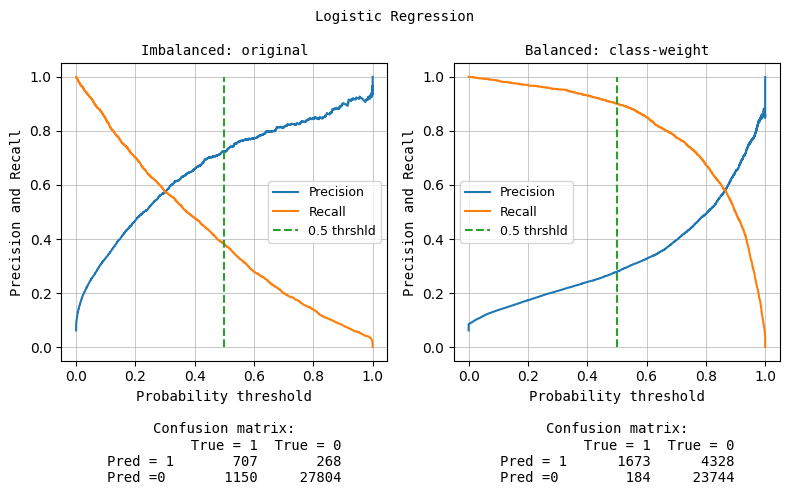

In [190]:
plt.figure(figsize=(8, 5))
for i in (1, 2):
    if i == 1:
        pipe = make_pipeline(column_transformer_lm, LogisticRegression())
        title = 'Imbalanced: original'
    else: # i == 2
        pipe = make_pipeline(column_transformer_lm, LogisticRegression(class_weight='balanced'))
        title = 'Balanced: class-weight'
    plt.subplot(1, 2, i)
    pipe.fit(X_val, y_val)
    precision, recall, thresholds = precision_recall_curve(y_val, pipe.predict_proba(X_val)[:, 1]) 
    plt.plot(thresholds, precision[:-1], color='C0', label='Precision')
    plt.plot(thresholds, recall[:-1], color='C1', label='Recall')
    plt.vlines(0.5, 0.0, 1.0, ls='--', color='C2', label='0.5 thrshld')
    plt.ylabel('Precision and Recall', size=10, fontfamily='monospace')
    cm = pd.DataFrame(
        confusion_matrix(y_val, pipe.predict(X_val), labels=[1, 0]),
        columns=['Pred = 1', 'Pred =0'],
        index=['True = 1', 'True = 0']).T
    plt.xlabel(f'Probability threshold\n\nConfusion matrix:\n{cm}', size=10, fontfamily='monospace')
    plt.title(f'{title}', size=10, fontfamily='monospace')
    plt.legend(fontsize=9)
    plt.grid(lw=0.5)
plt.suptitle('Logistic Regression', size=10, fontfamily='monospace')
plt.tight_layout();

These two plots confirm that, regardless of the threshold and balancing the target classes, the classifier is good at either precision or recall. So, we should focus on building a better classifier. Since our target metric is precision, we will not use balancing techniques in our final pipeline.

* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models

Consider 6 models, discussed in [2.2](#encoding). First let's see the models' performance with default hyperparameters (out of the box). As with assessing the balancers, we will use `X_val` to speed up and cross-validation on it. Note that this is not final model training, that's why we use `X_val` here for rough comparison of the models.

In [271]:
models_to_eval = [{'name': 'LR', 'model': LogisticRegression(random_state=seed, n_jobs=-1), 'transformer': column_transformer_lm},
                  {'name': 'SVC', 'model': CalibratedClassifierCV(LinearSVC(random_state=seed)), 'transformer': column_transformer_lm},
                  {'name': 'RF', 'model': RandomForestClassifier(random_state=seed, n_jobs=-1), 'transformer': column_transformer_dt},
                  {'name': 'XGBoost', 'model': XGBClassifier(device=device, random_state=seed, n_jobs=-1), 'transformer': column_transformer_dt},
                  {'name': 'LightGBM', 'model': LGBMClassifier(random_state=seed, n_jobs=-1), 'transformer': column_transformer_dt},
                  {'name': 'CatBoost', 'model': CatBoostClassifier(random_state=seed), 'transformer': column_transformer_dt}
                  ]

In [272]:
print('Model:')
for model_to_eval in models_to_eval:
    pipe = make_pipeline(model_to_eval['transformer'], model_to_eval['model'])
    metrics = cross_validate(pipe, X_val, y_val, scoring=['precision', 'recall', 'f1'], cv=5, n_jobs=-1)
    model_to_eval['mean_precision'] = metrics['test_precision'].mean()
    model_to_eval['mean_recall'] = metrics['test_recall'].mean()
    model_to_eval['mean_f1'] = metrics['test_f1'].mean()
    pipe.fit(X_val, y_val)
    precision, recall, _ = precision_recall_curve(y_val, pipe.predict_proba(X_val)[:,1])
    pr_auc = auc(recall, precision)
    model_to_eval['precisions'] = precision
    model_to_eval['recalls'] = recall
    model_to_eval['pr_auc'] = pr_auc
    print(f"{model_to_eval['name']:<8} ({metrics['fit_time'].mean()+metrics['score_time'].mean():.2f}s)")

Model:
LR       (0.64s)


c:\Users\andre\mambaforge\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\andre\mambaforge\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\andre\mambaforge\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\andre\mambaforge\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\andre\mambaforge\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual`

SVC      (4.05s)
RF       (6.61s)
XGBoost  (2.38s)
[LightGBM] [Info] Number of positive: 1857, number of negative: 28072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 29929, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062047 -> initscore=-2.715810
[LightGBM] [Info] Start training from score -2.715810
LightGBM (1.15s)
Learning rate set to 0.043977
0:	learn: 0.6146222	total: 22.9ms	remaining: 22.8s
1:	learn: 0.5347578	total: 42.6ms	remaining: 21.3s
2:	learn: 0.4692310	total: 65.5ms	remaining: 21.8s
3:	learn: 0.4213283	total: 87.5ms	remaining: 21.8s
4:	learn: 0.3806969	total: 108ms	remaining: 21.6s
5:	learn: 0.3459980	total: 132ms	remaining: 21.8s
6:	learn: 0.3184800	total: 154ms	remaining: 21.9s
7:	learn: 0.2924574	total: 178ms	remaining: 22.1s
8:	le

In [321]:
models_cv = pd.DataFrame(models_to_eval).drop(columns=['model', 'transformer'])
models_cv.sort_values(by='mean_precision', ascending=False)

,name,mean_precision,mean_recall,mean_f1,precisions,recalls,pr_auc
2,RF,0.754217,0.382854,0.507661,"[0.062046844197935117, 0.12805385896724042, 0....","[1.0, 0.9935379644588045, 0.9865374259558427, ...",0.760978
4,LightGBM,0.746821,0.424324,0.540767,"[0.062046844197935117, 0.062048917401764235, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.726469
5,CatBoost,0.739484,0.425424,0.538520,"[0.062046844197935117, 0.062048917401764235, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.734943
1,SVC,0.727503,0.368324,0.488290,"[0.062046844197935117, 0.062065508021390374, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.601185
0,LR,0.718400,0.374789,0.492243,"[0.062046844197935117, 0.062319618766360156, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.603403
3,XGBoost,0.710942,0.419516,0.526159,"[0.062046844197935117, 0.062048917401764235, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.717025


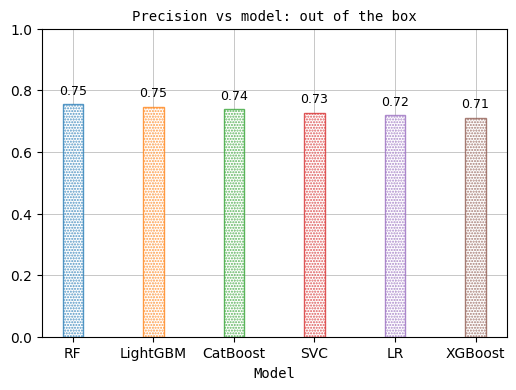

In [319]:
plot_bar(models_cv.sort_values(by='mean_precision', ascending=False), 'name', 'mean_precision', 'Model', 'Precision vs model: out of the box', bar_label=True, ylim=[0.0, 1.0], rot=0)

Let's also take a look at the Precision-Recall curves for all models. AUC (Area Under the Curve) is shown in the parentheses. The ideal classifier would have AUC = 1.0, and a naive classifier would have AUC = 0.5.

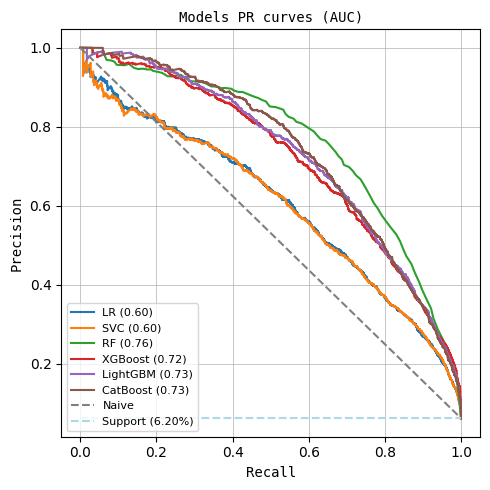

In [316]:
plt.figure(figsize=(5, 5))
for row in models_cv.iterrows():
    plt.plot(row[1]['recalls'], row[1]['precisions'], color=f'C{row[0]}', label=f"{row[1]['name']} ({row[1]['pr_auc']:.2f})")
plt.plot([0.0, 1.0], [1.0, y_val.mean()], ls='--', color='grey', label='Naive')
plt.hlines(y_val.mean(), xmin=0.0, xmax=1.0, ls='--', color='lightblue', label=f'Support ({y_val.mean():.2%})')
plt.xlabel('Recall', size=10, fontfamily='monospace')
plt.ylabel('Precision', size=10, fontfamily='monospace')
plt.legend(loc='lower left', fontsize=8)
plt.grid(lw=0.5)
plt.title('Models PR curves (AUC)', size=10, fontfamily='monospace')
plt.tight_layout();

We can confirm once again that decision tree-based models perform better than linear models. Random Forest is the leader here, but don't forget that we quickly trained and validated all models on only a small part of our data. We'll identify the true leader below. By the way, this plot is a good confirmation that __we can build a better classifier even with imbalanced data by using different machine learning algorithms__.

Now, it's time to fine-tune our models to find best estimators within each subset of models. To do that, we'll use grid search over the following models' hyperparameters:
- Logistic Regression and Linear SVC:
    - C (inverse of coefficient of regularization $\lambda$). If C = 1.0, then no regularization is applied to the model's weights;
    - penalty (type of regularization norm): no, $L_{1}$, $L_{2}$, both (not all values are compatible with every solver);
- Random Forest:
    - number of trees in the forest;
    - maximal depth of each tree. If maximal depth is not set, then nodes are split until all leaves are pure, which may cause high variance and thus overfitting;
- XGBoost, LightGBM, and CatBoost:
    - number of estimators (trees) in ensemble
    - maximal depth of each tree. If maximal depth is not set, then nodes are split until all leaves are pure. Usually the trees are shallow (not deep).

In [218]:
param_grid = [
    {
        'column_transformer': [column_transformer_lm],
        'estimator': [LogisticRegression(random_state=seed, n_jobs=-1)],
        'estimator__C': [0.1, 1.0, 10.0],
        'estimator__penalty': [None, 'l2']
    },
    {
        'column_transformer': [column_transformer_lm],
        'estimator': [LinearSVC(random_state=seed)],
        'estimator__C': [0.1, 1.0, 10.0],
        'estimator__penalty': ['l2']
    },
    {
        'column_transformer': [column_transformer_dt],
        'estimator': [RandomForestClassifier(random_state=seed, n_jobs=-1)],
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [10, 20, 50]
    },
    {
        'column_transformer': [column_transformer_dt],
        'estimator': [XGBClassifier(device=device, random_state=seed, n_jobs=-1)],
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [3, 5, 7, 9]
    },
        {
        'column_transformer': [column_transformer_dt],
        'estimator': [LGBMClassifier(random_state=seed, n_jobs=-1)],
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [3, 5, 7, 9]
    },
    {
        'column_transformer': [column_transformer_dt],
        'estimator': [CatBoostClassifier(random_state=seed)],
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [3, 5, 7, 9]
    }
]

In [219]:
model_opt = Pipeline([('column_transformer', None), ('estimator', None)])
grid_pipe = GridSearchCV(estimator=model_opt, param_grid=param_grid, cv=5, refit=False, scoring=['precision', 'recall', 'f1'], n_jobs=-1)
grid_pipe.fit(X_val, y_val)

c:\Users\andre\mambaforge\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer', None),
                                       ('estimator', None)]),
             n_jobs=-1,
             param_grid=[{'column_transformer': [ColumnTransformer(n_jobs=-1,
                                                                   transformers=[('num_cols',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['age',
                                                                                   'capital '
                                                                                   'gains',
                                                                                   'capital '
                                                                                   'losses',
                                                                                   'dividends '...
                                                                                   'stat',
                                                                                   'class '
                                                                                   'of '
                                                                                   'worker',
                                                                                   'veterans '
                                                                                   'benefits',
                                                                                   'tax '
                                                                                   'filer '
                                                                                   'stat',
                                                                                   'sex',
                                                                                   'full '
                                                                                   'or '
                                                                                   'part '
                                                                                   'time '
                                                                                   'employment '
                                                                                   'stat',
                                                                                   'marital '
                                                                                   'stat',
                                                                                   'education',
                                                                                   'group'])])],
                          'estimator': [<catboost.core.CatBoostClassifier object at 0x0000021D63CBA590>],
                          'estimator__max_depth': [3, 5, 7, 9],
                          'estimator__n_estimators': [100, 200, 300]}],
             refit=False, scoring=['precision', 'recall', 'f1'])

In [227]:
grid_results = pd.DataFrame(grid_pipe.cv_results_)

In [243]:
grid_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_column_transformer,param_estimator,param_estimator__C,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,model
0,0.958940,0.129697,0.158085,0.041157,"ColumnTransformer(n_jobs=-1,\n ...","LogisticRegression(n_jobs=-1, random_state=0)",0.1,None,NaN,NaN,{'column_transformer': ColumnTransformer(n_job...,0.731579,0.716981,0.735450,0.691919,0.743316,0.723849,0.018111,40,0.342365,0.428169,0.407625,0.368280,0.362924,0.381872,0.031341,43,0.466443,0.536155,0.524528,0.480702,0.487719,0.499110,0.026662,44,LogisticRegression
1,1.024416,0.069095,0.153230,0.016637,"ColumnTransformer(n_jobs=-1,\n ...","LogisticRegression(n_jobs=-1, random_state=0)",0.1,l2,NaN,NaN,{'column_transformer': ColumnTransformer(n_job...,0.740541,0.721154,0.734043,0.695876,0.744565,0.727236,0.017573,30,0.337438,0.422535,0.404692,0.362903,0.357702,0.377054,0.031548,48,0.463621,0.532860,0.521739,0.477032,0.483245,0.495699,0.026801,50,LogisticRegression
2,1.112886,0.030899,0.135928,0.007871,"ColumnTransformer(n_jobs=-1,\n ...","LogisticRegression(n_jobs=-1, random_state=0)",1.0,None,NaN,NaN,{'column_transformer': ColumnTransformer(n_job...,0.731579,0.716981,0.735450,0.691919,0.743316,0.723849,0.018111,40,0.342365,0.428169,0.407625,0.368280,0.362924,0.381872,0.031341,43,0.466443,0.536155,0.524528,0.480702,0.487719,0.499110,0.026662,44,LogisticRegression


In [277]:
grid_results['model'] = grid_results['param_estimator'].apply(lambda x: x.__str__()).str.split('(', expand=True)[0]
grid_results.loc[lambda x: x['model'].str.contains('CatBoostClassifier'), 'model'] = 'CatBoostClassifier'
grid_results['model'] = grid_results['model'].str.replace('LogisticRegression', 'LR') \
                            .str.replace('LinearSVC', 'SVC') \
                            .str.replace('RandomForestClassifier', 'RF') \
                            .str.replace('XGBClassifier', 'XGBoost') \
                            .str.replace('LGBMClassifier', 'LightGBM') \
                            .str.replace('CatBoostClassifier', 'CatBoost')

In [320]:
# Best models in their corresponding subsets
best_models = grid_results.iloc[grid_results.groupby('model')['mean_test_f1'].idxmax()]
best_models[['model', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].sort_values(by='mean_test_precision', ascending=False)

,model,mean_test_precision,mean_test_recall,mean_test_f1
44,CatBoost,0.776476,0.413321,0.538391
8,SVC,0.754182,0.300069,0.427845
12,RF,0.744327,0.400010,0.519897
36,LightGBM,0.732544,0.440728,0.549596
18,XGBoost,0.730929,0.444473,0.551913
5,LR,0.724623,0.381872,0.499266


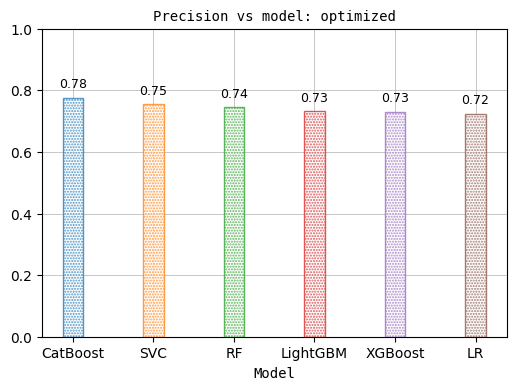

In [318]:
plot_bar(best_models.sort_values(by='mean_test_precision', ascending=False), 'model', 'mean_test_precision', 'Model', 'Precision vs model: optimized', bar_label=True, ylim=[0.0, 1.0], rot=0)

Now, let's take a look at the Precision-Recall curves for all best models in their corresponding subsets.

In [328]:
grid_results[grid_results['model'] == 'LightGBM']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_column_transformer,param_estimator,param_estimator__C,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,model
30,9.797753,1.475563,0.132289,0.015196,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,3,100,{'column_transformer': ColumnTransformer(n_job...,0.724891,0.750000,0.732719,0.745000,0.740000,0.738522,0.008892,19,0.408867,0.422535,0.466276,0.400538,0.386423,0.416928,0.027316,29,0.522835,0.540541,0.569892,0.520979,0.507719,0.532393,0.021462,26,LightGBM
31,6.033141,1.657116,0.124623,0.007293,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,3,200,{'column_transformer': ColumnTransformer(n_job...,0.705645,0.748792,0.723214,0.756219,0.757576,0.738289,0.020478,20,0.431034,0.436620,0.475073,0.408602,0.391645,0.428595,0.028269,17,0.535168,0.551601,0.573451,0.530541,0.516351,0.541423,0.019573,8,LightGBM
32,3.975299,0.671884,0.120094,0.006466,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,3,300,{'column_transformer': ColumnTransformer(n_job...,0.706383,0.746411,0.706140,0.772727,0.748768,0.736086,0.026035,22,0.408867,0.439437,0.472141,0.411290,0.396867,0.425720,0.027084,21,0.517941,0.553191,0.565905,0.536842,0.518771,0.538530,0.018876,10,LightGBM
33,3.386301,0.200481,0.116551,0.006816,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,5,100,{'column_transformer': ColumnTransformer(n_job...,0.725738,0.738318,0.688889,0.756345,0.722222,0.726302,0.022198,32,0.423645,0.445070,0.454545,0.400538,0.407311,0.426222,0.020888,19,0.534992,0.555360,0.547703,0.523726,0.520868,0.536530,0.013349,17,LightGBM
34,4.429249,0.194228,0.123183,0.005522,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,5,200,{'column_transformer': ColumnTransformer(n_job...,0.723849,0.768116,0.675214,0.734300,0.725225,0.725341,0.029749,34,0.426108,0.447887,0.463343,0.408602,0.420366,0.433261,0.019720,13,0.536434,0.565836,0.549565,0.525043,0.532231,0.541822,0.014417,7,LightGBM
35,5.930766,0.359638,0.118453,0.009762,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,5,300,{'column_transformer': ColumnTransformer(n_job...,0.735931,0.784689,0.682008,0.739130,0.715596,0.731471,0.033494,25,0.418719,0.461972,0.478006,0.411290,0.407311,0.435460,0.028878,7,0.533752,0.581560,0.562069,0.528497,0.519135,0.545003,0.023220,4,LightGBM
36,3.206852,0.188158,0.120731,0.006421,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,7,100,{'column_transformer': ColumnTransformer(n_job...,0.721992,0.726496,0.725225,0.764706,0.724299,0.732544,0.016148,23,0.428571,0.478873,0.472141,0.419355,0.404700,0.440728,0.029477,2,0.537867,0.577250,0.571936,0.541667,0.519263,0.549596,0.021837,2,LightGBM
37,5.305472,0.442153,0.111707,0.010096,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,7,200,{'column_transformer': ColumnTransformer(n_job...,0.698745,0.736607,0.703057,0.747525,0.733990,0.723985,0.019435,39,0.411330,0.464789,0.472141,0.405914,0.389034,0.428641,0.033418,16,0.517829,0.569948,0.564912,0.526132,0.508532,0.537471,0.025138,15,LightGBM
38,7.945690,0.344515,0.127529,0.012913,"ColumnTransformer(n_jobs=-1,\n ...","LGBMClassifier(n_jobs=-1, random_state=0)",NaN,NaN,7,300,{'column_transformer': ColumnTransformer(n_job...,0.711207,0.747664,0.706667,0.748744,0.723301,0.727516

* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### <a id="summary"></a>[25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?

* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)

* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero